# Strategic Thinking Final CA3 - Capstone Project 


- Github Link : https://github.com/CCT-Dublin/ca1-capstone-project-proposal-Aline-Menezes-Silva

## Title: Sales Prediction and Demand Forecast

## Problem Statement:

In the fast-paced retail sector, precise sales forecasting is essential for efficient operations, stock management, and maintaining profitability. This project uses a four-year dataset from a US Based Candy Distribuitor to analyse trends and patterns.  By examining customer locations, factory deliveries, sales orders and product information, through exploratory data analysis (EDA), time series forecasting and regression techniques, the goal is to develop reliable predictions that help optimise business performance. The insights gained will support smarter decision-making, ensuring the distributor stays competitive and profitable.


## Data Description

- US Candy Distributor: 
The dataset includes Sales and geospatial factory to customer shipment data for a US national candy distributor, inlcuding information around customer & factory locations, sales orders & goals and product details.

https://mavenanalytics.io/data-playground?page=2&pageSize=5

- Candy_Sales.csv


#### Data Dictionary 

Most of the fields are self-explanatory.

- Row ID = Unique row identifier
- Order ID = Unique order identifier
- Order Date = Date of order
- Ship Mode = Shipping method of order
- Customer ID = Unique customer identifier
- Country/Region = Country or region of customer
- City = City of customer
- State/Province = State/province of customer
- Postal Code = Postal code / zip code of customer
- Division = Product division
- Region = Region of customer
- Product ID = Unique product identifier
- Product Name = Product long name
- Sales = otal sales value of order
- Units = Total units of order
- Gross = Profit Gross profit of order ( Sales - Cost )
- Cost = Cost to manufacture
- Factory = Factory Name



## Business questions

##### EDA Visualisation will be used to asnwer the business question>
What are the store performances in the different countries and states?

Which State is the best marketplace to sell candys ?

Which months of the year have the slowest sale?

- Optimising Sales Performance for a US Candy Distributor:
  
Which products will be in demand next quarter?

Which customers are at risk of churning?

What are the most efficient factory to customer shipping routes?

What about the least efficient?

Which product lines have the best product margin?

What will the candy poduction demand for next year?


##  Hypotheses 

##### Two hypothesis tests will be conducted to answear business qiestion and gain deeper insight into the business:

Hypotheses 1: Do products with higher unit costs have the same profit percentage as lower-cost products?

Hypotheses 2: Does the shipping mode significantly affect profitability?






Potential Test Approach:

Calculate correlation between Delivery_Time and Profit%

Perform a t-test comparing profit% between:

Fast deliveries (bottom quartile of Delivery_Time)

Slow deliveries (top quartile of Delivery_Time)

Alternatively, you could do an ANOVA test across multiple delivery time brackets

Additional Interesting Angles:

Does this relationship hold across all Categories or are some product categories more sensitive to delivery times?

Is the effect more pronounced in certain Regions?

Does the relationship change if you control for Shipping method?

Why This is Interesting:
This could provide actionable insights about whether the company should invest in faster delivery systems, or whether certain delivery time thresholds significantly impact profitability. The results could inform logistics strategy and pricing models.
Rationale:
- Faster shipping might reduce cart abandonment or attract premium customers, boosting profit margins despite higher costs.

Businesses often face a trade-off between speed of delivery and profitability

Faster deliveries might require more expensive shipping methods that cut into profits

Alternatively, longer deliveries might lead to customer dissatisfaction and thus require discounts

This could be particularly interesting if you segment by shipping method or region

## Import Libraries

In [1]:
#!pip install missingno

# Core Data Handling & Computation
import numpy as np
import pandas as pd
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

# Visualisation Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Preprocessing and Feature Engineering
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import (
    train_test_split, GridSearchCV, RandomizedSearchCV, 
    cross_val_score, TimeSeriesSplit, KFold
)
from sklearn.pipeline import Pipeline

# Machine Learning Models:

## Regression Models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Time Series Analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Model Evaluation Metrics
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_percentage_error,
    accuracy_score, classification_report
)
from math import sqrt

# Parallel Processing & Utilities
from joblib import Parallel, delayed
import time


## Reading the Datasets:

In [2]:
pd.set_option('display.max_columns', None) 

In [3]:
candy = pd.read_csv("Candy.csv")
candy.head(5)

,Row ID,Order ID,Order Date,Ship Mode,Customer ID,Country/Region,City,State/Province,Postal Code,Division,Region,Product ID,Product Name,Sales,Units,Gross Profit,Cost,Factory,Days to Ship
0,937,CA-2021-115777-CHO-NUT-13000,19 08 2021,Standard Class,115777,Canada,Montreal,Quebec,H1B,Chocolate,Atlantic,CHO-NUT-13000,Wonka Bar - Nutty Crunch Surprise,120.00,6,60.00,60.00,Lots ONuts,3
1,4750,CA-2023-169856-CHO-NUT-13000,7 05 2023,Standard Class,169856,Canada,Toronto,Ontario,M3C,NaN,Atlantic,CHO-NUT-13000,Wonka Bar - Nutty Crunch Surprise,120.00,6,60.00,60.00,Lots ONuts,3
2,8386,CA-2024-115777-CHO-NUT-13000,19 08 2024,Standard Class,115777,Canada,Montreal,Quebec,H1B,Chocolate,Atlantic,CHO-NUT-13000,Wonka Bar - Nutty Crunch Surprise,120.00,6,60.00,60.00,Lots ONuts,3
3,65,CA-2021-115238-CHO-FUD-51000,21 01 2021,Standard Class,115238,Canada,Toronto,Ontario,M7A,Chocolate,Atlantic,CHO-FUD-51000,Wonka Bar - Fudge Mallows,120.00,6,60.00,60.00,Lots ONuts,3
4,12,US-2021-130813-CHO-MIL-31000,6 01 2021,Second Class,130813,United States,Los Angeles,California,90049,Chocolate,Pacific,CHO-MIL-31000,Wonka Bar - Milk Chocolate,9.75,3,6.33,3.42,Wicked Choccys,2


## Data Preprocessing:

#### - Check the feature details 

In [4]:
candy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10194 entries, 0 to 10193
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Row ID          10194 non-null  int64  
 1   Order ID        10017 non-null  object 
 2   Order Date      10194 non-null  object 
 3   Ship Mode       10194 non-null  object 
 4   Customer ID     10194 non-null  int64  
 5   Country/Region  10085 non-null  object 
 6   City            10174 non-null  object 
 7   State/Province  10194 non-null  object 
 8   Postal Code     10194 non-null  object 
 9   Division        10148 non-null  object 
 10  Region          10194 non-null  object 
 11  Product ID      10194 non-null  object 
 12  Product Name    10170 non-null  object 
 13  Sales           10179 non-null  float64
 14  Units           10194 non-null  int64  
 15  Gross Profit    10194 non-null  float64
 16  Cost            10194 non-null  float64
 17  Factory         10194 non-null 

##### Dataset Overview:

The dataset contains 10,194 entries with 19 columns, covering order details, customer information and product data. Key fields include Order ID, Order Date, Ship Mode, Customer ID and location data (Country/Region, City, State/Province), alongside product-specific columns such as Product ID, Sales, Units, Gross Profit, and Cost. Most columns are complete, though a few (Order ID, Country/Region, Product Name) have minor missing values. Data types include floats, integers and strings.

#### - Check shape of data:

In [5]:
candy.shape

(10194, 19)

#### - Missing values: 

In [6]:
#Checking Null Values

candy.isnull().sum()

Row ID              0
Order ID          177
Order Date          0
Ship Mode           0
Customer ID         0
Country/Region    109
City               20
State/Province      0
Postal Code         0
Division           46
Region              0
Product ID          0
Product Name       24
Sales              15
Units               0
Gross Profit        0
Cost                0
Factory             0
Days to Ship        0
dtype: int64

#### - Visualising missing Values:

<Figure size 800x400 with 0 Axes>

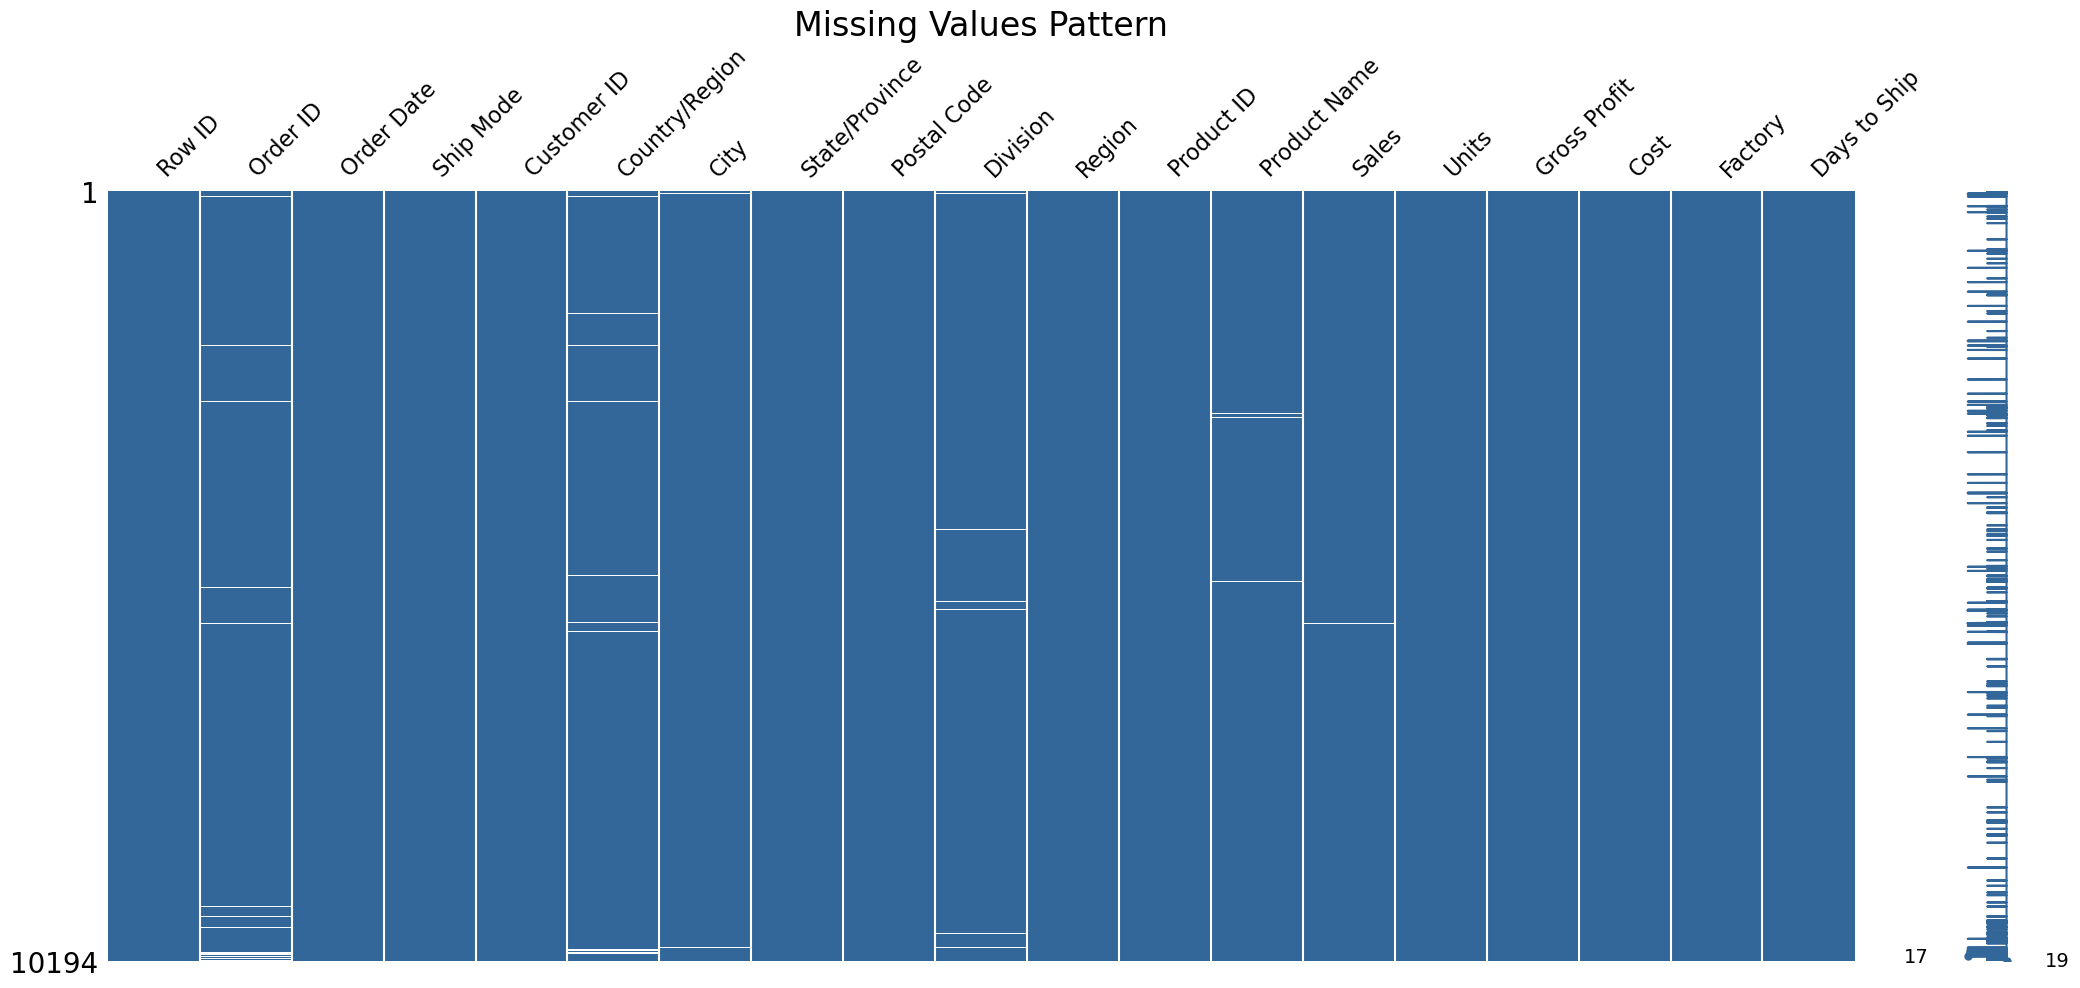

In [7]:
plt.figure(figsize=(8, 4))
msno.matrix(candy, color=(0.2, 0.4, 0.6)) 
plt.title('Missing Values Pattern', size=24)
plt.show()

#### - Handlying Missing Values

Since Customer ID , Region and Sales have very few missing values (<5% of the dataset), dropping rows is a safe and efficient strategy to maintain data integrity without significant loss.

In [8]:
candy= candy.dropna(subset=['Order ID', 'Country/Region', 'City', 'Division', 'Product Name', 'Sales'])

In [9]:
candy.isnull().sum()

Row ID            0
Order ID          0
Order Date        0
Ship Mode         0
Customer ID       0
Country/Region    0
City              0
State/Province    0
Postal Code       0
Division          0
Region            0
Product ID        0
Product Name      0
Sales             0
Units             0
Gross Profit      0
Cost              0
Factory           0
Days to Ship      0
dtype: int64

- The dataset has now been cleaned, with no remaining missing values.

#### Number of unique values in each column:

In [10]:
candy.nunique()

Row ID            9886
Order ID          8318
Order Date        1235
Ship Mode            4
Customer ID       4966
Country/Region       2
City               541
State/Province      59
Postal Code        653
Division             3
Region               4
Product ID          15
Product Name        15
Sales               82
Units               14
Gross Profit       111
Cost                85
Factory              5
Days to Ship         6
dtype: int64

#### - Drop Unwanted Features:

Since they do not contribute to the analysis and some introduce redundancy.

In [11]:
candy.drop(columns=['Row ID', 'Postal Code', 'City', 'Product ID'], inplace=True)

#### - Rename Columns and atibuites for readibility: 

In [12]:
candy = candy.rename(columns={
    'Division': 'Category',
    'Product Name': 'Product',
    'Order Date': 'Order_Date',
    'Ship Date': 'Ship_Date',
    'Gross Profit': 'Profit',
    'Customer ID': 'CustomerID',
     'Product ID': 'ProductID',
    'Order ID': 'OrderID',
    'Country/Region': 'Country',
    'State/Province': 'State',
    'Units': 'Qty',
    'Ship Mode': 'Ship_Mode',
    'Days to Ship': 'Ship_Time'
})


In [13]:
candy['Product'] = candy['Product'].str.replace('-', ' ')

In [14]:
## To remove all hyphens (-) from the Product column and replace them with spaces

candy['Product'] = candy['Product'].str.replace('-', ' ')

#### Checking for duplicated values:

In [15]:
dup = candy.duplicated().sum()
print(f"Number of duplicated rows: {dup}")


Number of duplicated rows: 301


In [16]:
duplicated = candy[candy.duplicated(keep='first')]
duplicated.head(5)

,OrderID,Order_Date,Ship_Mode,CustomerID,Country,State,Category,Region,Product,Sales,Qty,Profit,Cost,Factory,Ship_Time
19,CA-2021-153623-CHO-SCR-58000,24 11 2021,Standard Class,153623,Canada,Newfoundland and Labrador,Chocolate,Atlantic,Wonka Bar Scrumdiddlyumptious,100.00,5,50.00,50.0,Lots ONuts,3
23,US-2021-146591-CHO-TRI-54000,19 01 2021,First Class,146591,United States,Arizona,Chocolate,Pacific,Wonka Bar Triple Dazzle Caramel,18.75,5,12.25,6.5,Wicked Choccys,2
175,US-2021-114790-CHO-TRI-54000,11 03 2021,Second Class,114790,United States,Kentucky,Chocolate,Gulf,Wonka Bar Triple Dazzle Caramel,11.25,3,7.35,3.9,Wicked Choccys,2
202,US-2024-100223-CHO-SCR-58000,5 07 2024,Standard Class,100223,United States,Texas,Chocolate,Interior,Wonka Bar Scrumdiddlyumptious,32.40,9,22.50,9.9,Lots ONuts,4
219,US-2021-133424-CHO-SCR-58000,30 03 2021,Standard Class,133424,United States,Washington,Chocolate,Pacific,Wonka Bar Scrumdiddlyumptious,10.80,3,7.50,3.3,Lots ONuts,4


In [17]:
candy_df_drop = candy.drop_duplicates()
remaining_duplicates = candy.duplicated().sum()
print(f"Duplicates remaining after drop: {remaining_duplicates}")


Duplicates remaining after drop: 301


#### - Convert Data Type

In [18]:
candy['CustomerID'] = candy['CustomerID'].astype('Int64').astype(str)

In [19]:
candy['Order_Date'] = pd.to_datetime(candy['Order_Date'], dayfirst=True, errors='coerce')


In [20]:
print(f" start_date is from {candy['Order_Date'].min()} - end_date is to {candy['Order_Date'].max()}")

 start_date is from 2021-01-03 00:00:00 - end_date is to 2024-12-30 00:00:00


#### - Feature engineering 

- Since the machine learning models were underperforming, new features were developed to improve the results.

In [21]:
# Extract temporal features

candy['Order_Date'] = pd.to_datetime(candy['Order_Date'], dayfirst=True, errors='coerce')
candy['Order_Day'] = candy['Order_Date'].dt.day
candy['Order_Month'] = candy['Order_Date'].dt.month
candy['Order_Year'] = candy['Order_Date'].dt.year
candy['Order_DayOfWeek'] = candy['Order_Date'].dt.dayofweek
candy['Order_Quarter'] = candy['Order_Date'].dt.quarter

In [22]:
# Customer Order Frequency: Number of orders per customer.

candy['Customer_Order_Count'] = candy.groupby('CustomerID')['OrderID'].transform('count')

In [23]:
# Average Sales per Customer:

candy['Sales_Per_Customer'] = candy.groupby('CustomerID')['Sales'].transform('mean')

In [24]:
# Customer loyalty

candy['Customer_Tenure'] = candy.groupby('CustomerID')['Order_Date'].transform(lambda x: (x.max() - x.min()).days)

In [25]:
# Bulk order indicators

candy['Is_Bulk_Order'] = (candy['Qty'] > candy['Qty'].quantile(0.9)).astype(int)

In [26]:
# Product lifecycle (time since first order)

candy['Product_Age'] = candy.groupby('Product')['Order_Date'].rank(method='dense')

In [27]:
# Promotional periods 

candy['Is_Holiday'] = candy['Order_Month'].isin([10, 12]).astype(int)

In [28]:
candy['Order_Month_sin'] = np.sin(2 * np.pi * candy['Order_Month'] / 12)
candy['Order_DayOfWeek_cos'] = np.cos(2 * np.pi * candy['Order_DayOfWeek'] / 7)

In [29]:
# Price elasticity proxies

candy['Price_Per_Unit'] = candy['Sales'] / candy['Qty']
candy['Cost_Per_Unit'] = candy['Cost'] / candy['Qty']

## Descriptive analysis

In [30]:
candy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9886 entries, 0 to 10189
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   OrderID               9886 non-null   object        
 1   Order_Date            9886 non-null   datetime64[ns]
 2   Ship_Mode             9886 non-null   object        
 3   CustomerID            9886 non-null   object        
 4   Country               9886 non-null   object        
 5   State                 9886 non-null   object        
 6   Category              9886 non-null   object        
 7   Region                9886 non-null   object        
 8   Product               9886 non-null   object        
 9   Sales                 9886 non-null   float64       
 10  Qty                   9886 non-null   int64         
 11  Profit                9886 non-null   float64       
 12  Cost                  9886 non-null   float64       
 13  Factory               

##### Numerical Features:

In [31]:
candy[['Sales', 'Cost', 'Profit', 'Qty']].describe()

,Sales,Cost,Profit,Qty
count,9886.000000,9886.000000,9886.000000,9886.000000
mean,14.438227,4.948748,9.461881,3.872446
std,11.137400,4.989538,6.453915,2.187335
min,2.500000,1.000000,0.500000,1.000000
25%,7.200000,2.400000,4.980000,2.000000
50%,10.800000,3.900000,7.470000,3.000000
75%,18.000000,6.000000,12.250000,5.000000
max,260.000000,130.000000,130.000000,14.000000


- Sales: The average sale amount is 14.44, with a relatively high standard deviation 11.14, indicating significant variability. Sales range from 2.50 to 260, with the median (50th percentile) at 10.80, with some right-skewness due to higher maximum values.

- Cost: The mean cost is 4.95, with a standard deviation of 4.99, showing considerable spread. Costs vary from 1 to 130, while the median is 3.90, again indicating potential skewness from extreme high-cost items.

- Profit: The average profit is 9.46, with a standard deviation of 6.45. Profits range from 0.50 to 130, with the median at 7.47, reinforcing the presence of outliers or high-value transactions.

- Quantity Sold (Qty): The average quantity per transaction is 3.87 units, with a standard deviation of 2.19. The median is 3, and values range from 1 to 14 units,  whre most sales involve smaller quantities, with occasional bulk purchases

The wide ranges and high standard deviations suggest significant variability in sales, costs, and profits, possibly due to a mix of low- and high-value transactions. The medians are lower than the means for sales, cost, and profit, indicating right-skewed distributions where a few high-value transactions pull the average up. Profitability appears consistent relative to sales.

In [32]:
numerical = ['Sales', 'Cost', 'Profit', 'Qty']

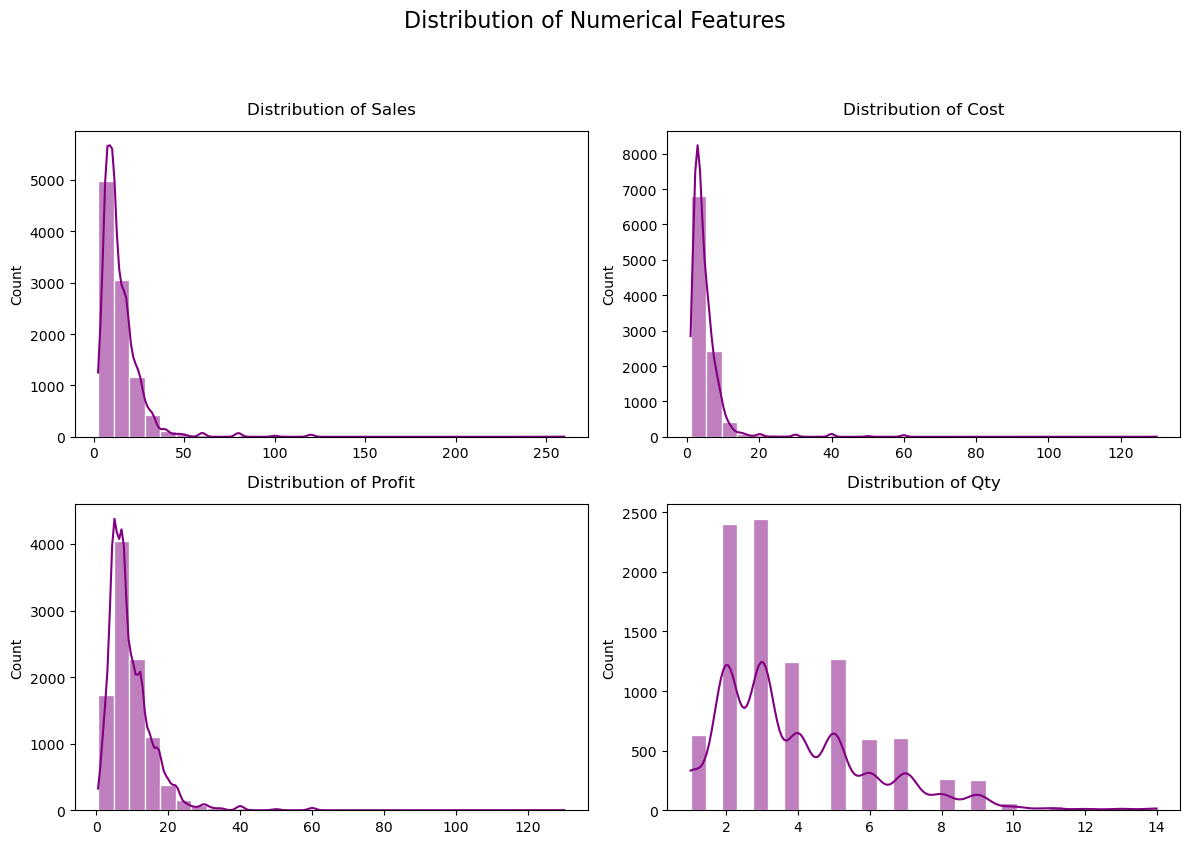

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8)) 
fig.suptitle('Distribution of Numerical Features', fontsize=16, y=1.05)  

for ax, col in zip(axes.flatten(), numerical):
    sns.histplot(candy[col], 
                 kde=True, 
                 bins=30, 
                 ax=ax, 
                 color='purple',
                 edgecolor='white')  
    ax.set_title(f'Distribution of {col}', pad=12)
    ax.set_xlabel('')  
    
plt.tight_layout()
plt.show()

##### Categorical Features 

In [34]:
candy.describe(include= object)

,OrderID,Ship_Mode,CustomerID,Country,State,Category,Region,Product,Factory
count,9886,9886,9886,9886,9886,9886,9886,9886,9886
unique,8318,4,4966,2,59,3,4,15,5
top,US-2021-155502-CHO-MIL-31000,Standard Class,115238,United States,California,Chocolate,Pacific,Wonka Bar Scrumdiddlyumptious,Lots ONuts
freq,5,5943,19,9695,1945,9614,3153,2049,5648


- OrderID: There are 8,318 unique order IDs, with the most frequent appearing 5 times.
- Ship_Mode: The most common shipping method is "Standard Class", used in 5,943 orders.
- CustomerID: There are 4,966 unique customers, with the most frequent customer (ID: 115238) placing 19 orders.
- Country: The majority of orders (9,695) come from the United States, with only a small portion from another country (likely international orders).
- State: California has the highest number of orders (1,945), followed by other states.
- Category: Chocolate is the most popular category, appearing in 9,614 orders.
- Region: The Pacific region has the most orders (3,153).
- Product: The "Wonka Bar Scrumdiddlyumptious" is the top-selling product, ordered 2,049 times.
- Factory: The factory "Lots ONuts" produces the majority of products (5,648 orders).

The Candy Distribuitor primarily serves US customers, with chocolate products being the most popular, particularly those manufactured by "Lots ONuts". The Pacific region and California are key markets and standard shipping is the preferred delivery method.

### - Check the Normality of the dataset 

Using Histogram with KDE and Q-Q Plot, along with Log Transformation to address/handle skewness:

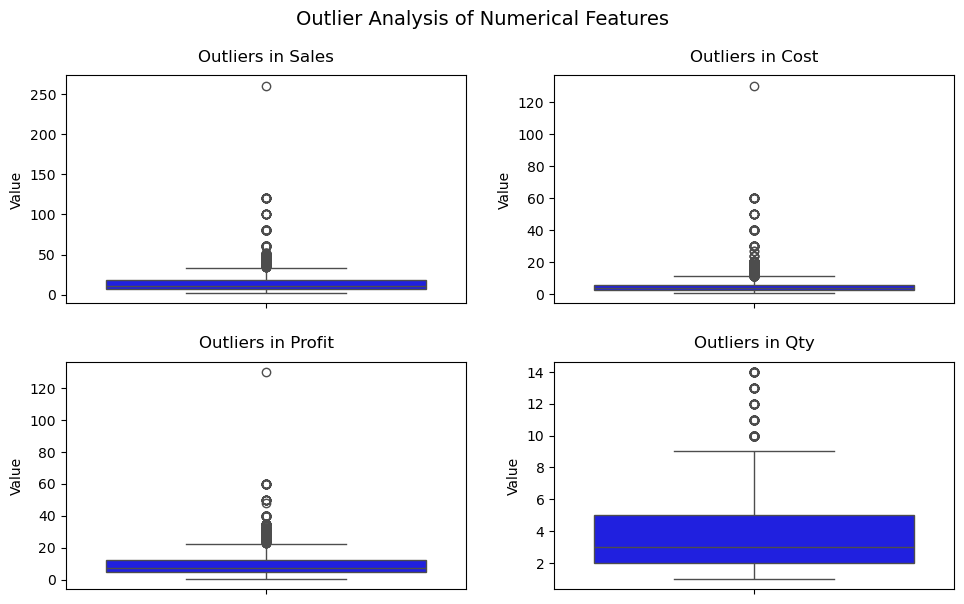

In [35]:
numerical = ['Sales', 'Cost', 'Profit', 'Qty']


plt.figure(figsize=(10, 6)) 

for i, col in enumerate(numerical, 1):
    plt.subplot(2, 2, i)  
    sns.boxplot(y=candy[col], color='blue')
    plt.title(f'Outliers in {col}', pad=10)
    plt.ylabel('Value')
    
plt.tight_layout(pad=2) 
plt.suptitle('Outlier Analysis of Numerical Features', y=1.02, fontsize=14)
plt.show()

The medians are lower than the means, indicating right-skewed distributions where a few high-value transactions pull the average up. 

#### -Log Transformation to treat data Skew:

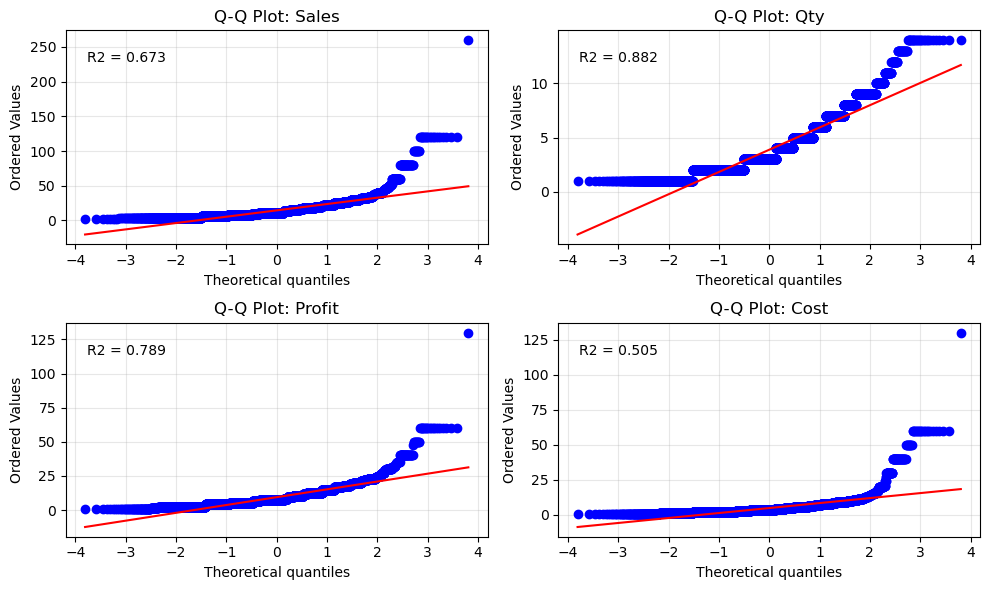

In [36]:
numeric_cols = ['Sales', 'Qty', 'Profit', 'Cost']


plt.figure(figsize=(10, 6))


for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 2, i)
    stats.probplot(candy[col], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot: {col}', fontsize=12)
    plt.grid(True, alpha=0.3)

    (osm, osr), (slope, intercept, r) = stats.probplot(candy[col], dist="norm")
    plt.annotate(f'R2 = {r**2:.3f}', xy=(0.05, 0.85), xycoords='axes fraction')

plt.tight_layout()
plt.show()

##### Features log transformation:

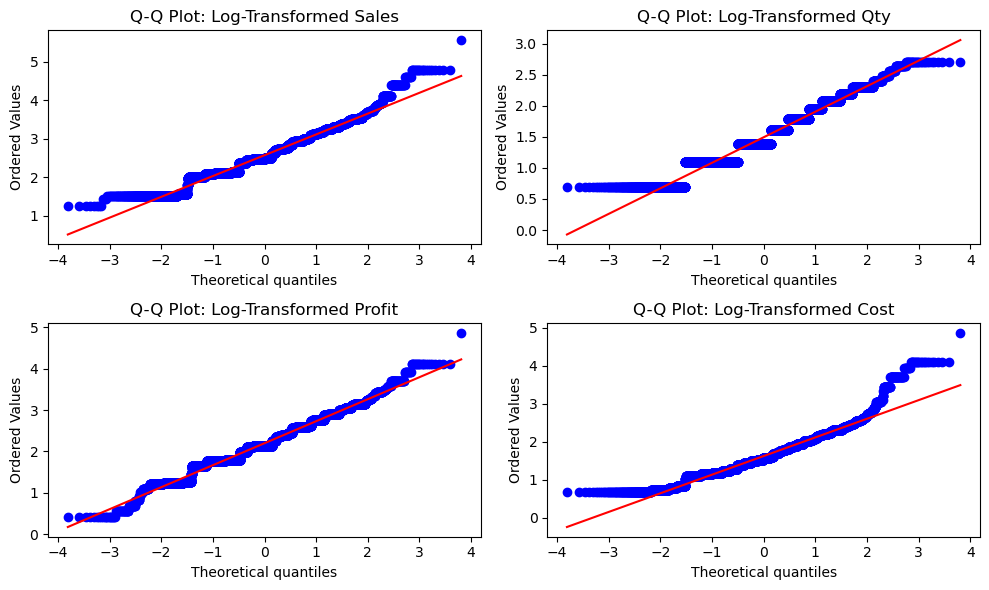

In [37]:
# log1p transformation to target columns:

candy[numeric_cols] = np.log1p(candy[numeric_cols])
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    stats.probplot(candy[col], dist="norm", plot=axes[i])
    axes[i].set_title(f'Q-Q Plot: Log-Transformed {col}')

plt.tight_layout()
plt.show()

- After applying the log transformation, the features now follow a distribution that is much closer to normal, as seen by their alignment with the red reference line.

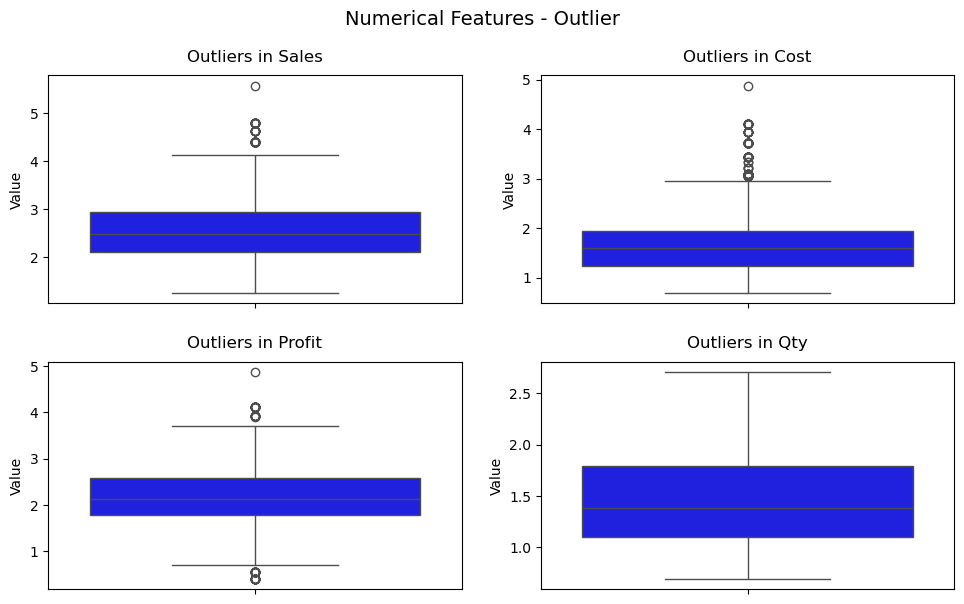

In [38]:
plt.figure(figsize=(10, 6)) 


for i, col in enumerate(numerical, 1):
    plt.subplot(2, 2, i)  
    sns.boxplot(y=candy[col], color='blue')
    plt.title(f'Outliers in {col}', pad=10)
    plt.ylabel('Value')
    
plt.tight_layout(pad=2)  
plt.suptitle('Numerical Features - Outlier', y=1.02, fontsize=14)
plt.show()

- The dataset had a long tail, with a few extremely high sales values skewing the distribution. Applying a log transform made the data more symmetrical by reducing the impact of these extremes. Previously, the boxplot showed many outliers due to this skew, but after transformation, the values are better balanced. This improvement aligns with regression models’ preference for normally distributed data. :)

# Exploratory Data Analysis EDA:

In [39]:
candy_df = candy.copy(deep=True)

### 1. Sales & Profit Analysis


#### 1.1 Annual Sales: 

In [40]:
candy_df['Order_Year'] = candy_df['Order_Date'].dt.year
annual_sales = candy_df.groupby('Order_Year')['Sales'].sum().reset_index()

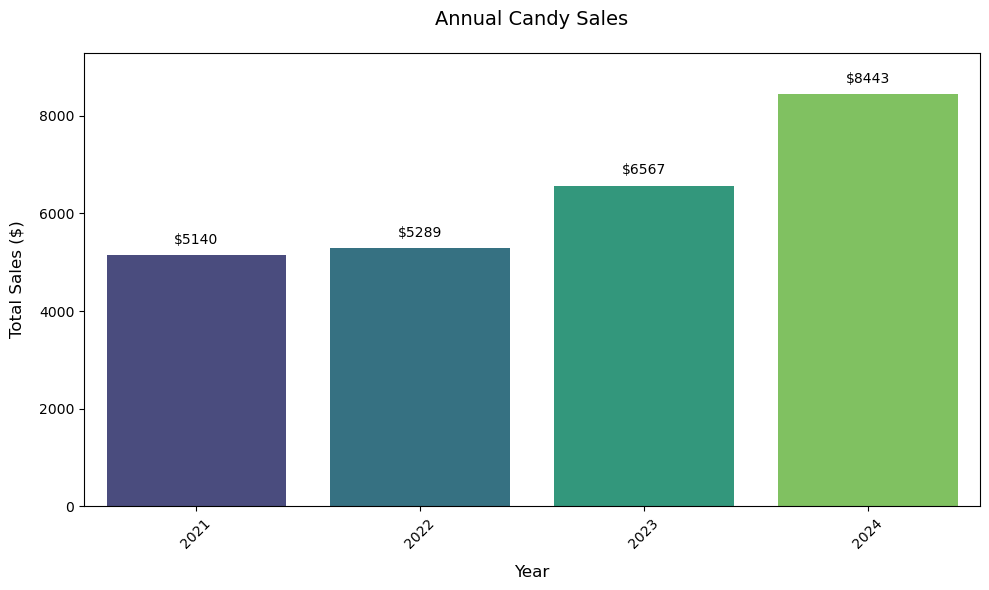

In [41]:
plt.figure(figsize=(10, 6))

ax = sns.barplot(x='Order_Year', y='Sales', data=annual_sales, palette='viridis')
ax.grid(False) 

plt.title('Annual Candy Sales', fontsize=14, pad=20)
plt.xlabel('Year', fontsize=12, labelpad=10)
plt.ylabel('Total Sales ($)', fontsize=12, labelpad=10)
plt.xticks(rotation=45)


max_sales = annual_sales['Sales'].max()
label_offset = 0.02 * max_sales  


for index, row in annual_sales.iterrows():
    y_pos = min(row['Sales'] + label_offset, max_sales * 1.05)  
    ax.text(index, 
            y_pos, 
            f'${row["Sales"]:.0f}', 
            ha='center', 
            va='bottom',
            fontsize=10)

plt.ylim(0, max_sales * 1.1)
plt.tight_layout()
plt.show()

The barchart shows a consistent year-on-year increase in sales, rising from 5,140.00 in 2021 to 8,443.00 in 2024, indicating strong growth over the four-year period. The most significant jump occurred between 2023 (6,567.00) and 2024 (8,443.00), sshowing an accelerated performance in the most recent year.

#### - 1.2 Sales per Country: 

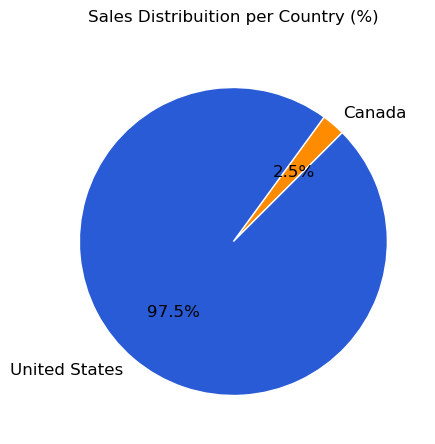

In [42]:
country_sales = candy_df.groupby('Country')['Sales'].sum()

plt.figure(figsize=(5, 5))
country_sales.plot.pie(
    colors=['#ff8c00' , '#2a5bd7'],
    autopct='%.1f%%',
    fontsize=12,
    wedgeprops={'edgecolor': 'white'},
    startangle=45,
)
plt.ylabel('') 
plt.title('Sales Distribuition per Country (%)', pad=20)
plt.show()

- The majority of orders 97.5% come from the United States, with only a small portion 2.5% from Canada. 

#### 1.3 Cross-Country Comparison: How do sales and profit compare across different countries, and what patterns emerge in their relationship?

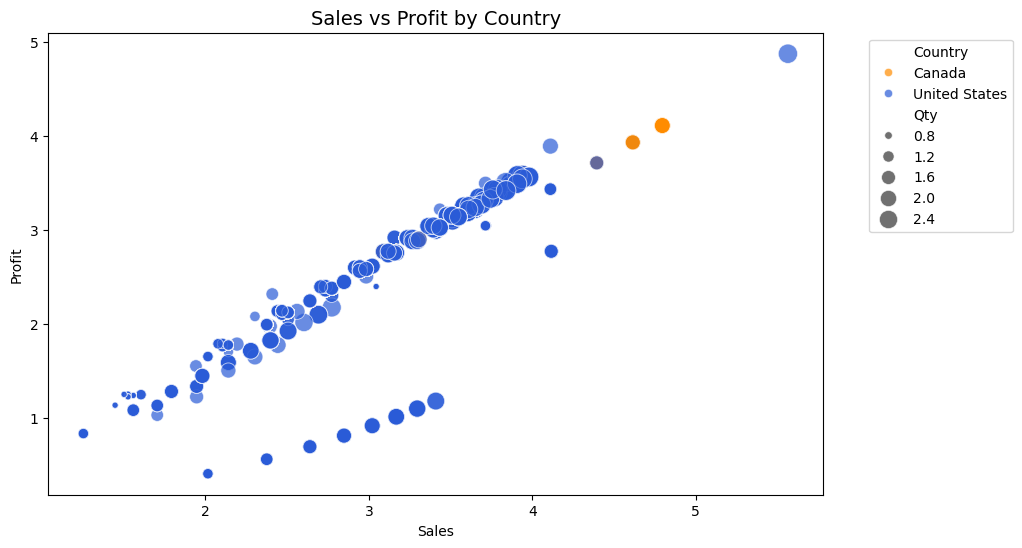

In [43]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Sales', y='Profit', data=candy_df,
                hue='Country', palette=['#ff8c00', '#2a5bd7'],
                alpha=0.7, size='Qty', sizes=(20, 200))
plt.title('Sales vs Profit by Country', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

- The chart shows significantly stronger sales and profitability in the US market compared to Canada. While the US demonstrates consistent high-volume transactions driving substantial profits, Canada's market activity appears limited to fewer but larger bulk purchases. Some somes has very low profit. 

#### 1.4 Regional Trends: How do sales volume and profitability margins vary across states, and are there significant regional differences?


In [44]:
# Calculate stats and sort by sales
state_stats = candy_df.groupby('State').agg({'Sales':'sum', 'Profit':'sum'})
state_stats['Profit Margin'] = state_stats['Profit'] / state_stats['Sales']

# Display top 5 states formatted nicely
top_states = state_stats.nlargest(5, 'Sales').style.format({
    'Sales': '${:,.2f}',
    'Profit': '${:,.2f}', 
    'Profit Margin': '{:.2%}'
})

top_states

,Sales,Profit,Profit Margin
State,,,
California,"$4,996.82","$4,276.15",85.58%
New York,"$2,771.00","$2,364.66",85.34%
Texas,"$2,449.52","$2,096.15",85.57%
Pennsylvania,"$1,450.26","$1,233.14",85.03%
Washington,"$1,251.28","$1,071.94",85.67%


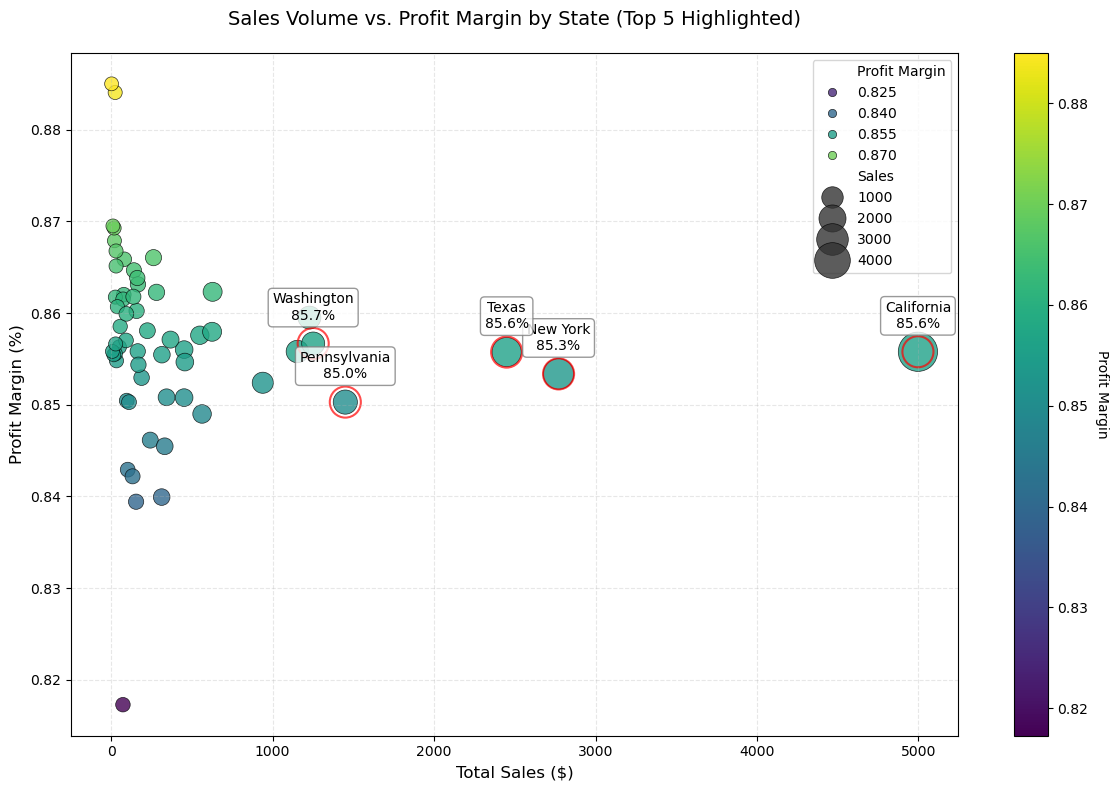

In [45]:
plt.figure(figsize=(12, 8))
ax = plt.gca() 
scatter = sns.scatterplot(
    data=state_stats, 
    x='Sales', 
    y='Profit Margin', 
    size='Sales',
    sizes=(100, 800),
    hue='Profit Margin', 
    palette='viridis',
    alpha=0.8,
    edgecolor='black',
    linewidth=0.5,
    ax=ax 
)

plt.title('Sales Volume vs. Profit Margin by State (Top 5 Highlighted)', fontsize=14, pad=20)
plt.xlabel('Total Sales ($)', fontsize=12)
plt.ylabel('Profit Margin (%)', fontsize=12)
plt.grid(linestyle='--', alpha=0.3)

# top 5 states
top_5 = state_stats.nlargest(5, 'Sales')
for state in top_5.index:
    ax.scatter(
        x=top_5.loc[state, 'Sales'],
        y=top_5.loc[state, 'Profit Margin'],
        s=500,
        facecolors='none',
        edgecolors='red',
        linewidths=1.5,
        alpha=0.7
    )
    ax.annotate(
        f"{state}\n{top_5.loc[state,'Profit Margin']:.1%}",
        (top_5.loc[state, 'Sales'], top_5.loc[state, 'Profit Margin']),
        textcoords="offset points",
        xytext=(0,15),
        ha='center',
        va='bottom',
        fontsize=10,
        bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='gray', alpha=0.8)
    )

norm = plt.Normalize(state_stats['Profit Margin'].min(), state_stats['Profit Margin'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)  
cbar.set_label('Profit Margin', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()




- California dominates in absolute sales (4,996.82) and profit (4,276.15), though Washington achieves the highest profit margin (85.67%) among the top five states, indicating superior cost efficiency despite its smaller sales volume (1,251.28). New York and Texas show nearly identical margins (85.5%) to California, suggesting consistent operational performance across these high-volume markets, while Pennsylvania's slightly lower margin (85.03%) may indicate opportunities for cost optimisation. Notably, all five states maintain strong margins above 85%, demonstrating generally effective pricing strategies and cost control across key markets, with Washington's outlier performance potentially offering best practices for others to emulate.

#### 1.5 Growth Over Time: How do sales growth trends vary across different states over time?

<Figure size 1200x500 with 0 Axes>

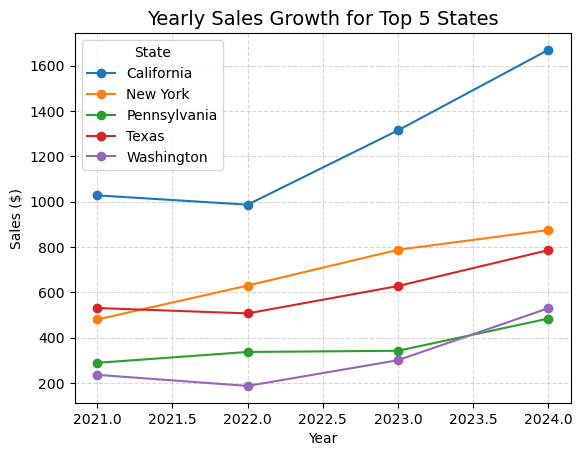

In [46]:
 #Growth Trends by State

state_sales = candy_df.groupby('State')['Sales'].sum().sort_values(ascending=False)
top_states = state_sales.head(5).index
yearly_sales = candy_df[candy_df['State'].isin(top_states)].groupby(['State', 'Order_Year'])['Sales'].sum().unstack()

plt.figure(figsize=(12, 5))
yearly_sales.T.plot(marker='o')
plt.title('Yearly Sales Growth for Top 5 States', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Sales ($)')
plt.grid(linestyle='--', alpha=0.5)
plt.legend(title='State')
plt.show();

- The year on year sales analysis reveals strong growth across all key states, with California maintaining market dominance (reaching 1,669k in 2024) and showing consistent annual expansion. New York demonstrates steady progress (from 480k to 875k), while Texas exhibits particularly robust recovery post-2022 (jumping from 507k to 785k). Washington stands out with remarkable acceleration in 2024 (a 77% surge from 2023 to 529k), suggesting successful market initiatives. Pennsylvania, though showing more modest growth, maintained stable increases each year. The data indicates all states benefited from improving market conditions, with California's exceptional performance potentially reflecting both market size and operational advantages.

#### 1.6 Seasonality: Which months experience the lowest sales performance?

In [47]:
candy_df['Month_Name'] = candy_df['Order_Date'].dt.month_name()

monthly_sales = candy_df.groupby(['Order_Month', 'Month_Name'])['Sales'].sum().reset_index()
monthly_sales = monthly_sales.sort_values('Order_Month')

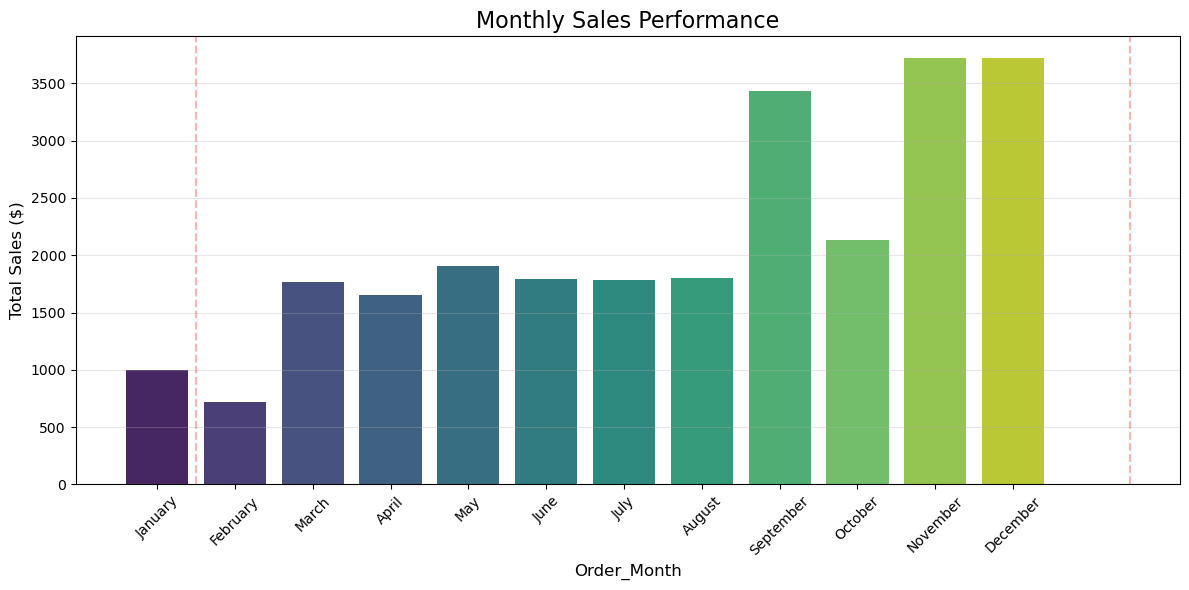

In [48]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Month_Name', y='Sales', data=monthly_sales, palette='viridis')


plt.title('Monthly Sales Performance', fontsize=16)
plt.xlabel('Order_Month', fontsize=12)
plt.ylabel('Total Sales ($)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

lowest_month = monthly_sales.loc[monthly_sales['Sales'].idxmin(), 'Month_Name']
plt.axvline(x=monthly_sales['Order_Month'].min()-0.5, color='red', linestyle='--', alpha=0.3)
plt.axvline(x=monthly_sales['Order_Month'].max()+0.5, color='red', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [49]:
slowest_months = monthly_sales.nsmallest(3, 'Sales')[['Month_Name', 'Sales']]
print("Slowest Sales Months:")
print(slowest_months.to_string(index=False))

Slowest Sales Months:
Month_Name       Sales
  February  721.843253
   January 1002.513601
     April 1653.500572


- The monthly sales analysis reveals a clear seasonal pattern, with December and November  emerging as peak sales months, likely driven by holiday demand, followed by September which may reflect back to school purchasing. Summer months (May-August) show consistently strong performance , while February appears to be the weakest month, potentially due to post-holiday lulls. Notably, sales triple from the lowest (February) to highest (December) months, suggesting significant seasonality that could inform inventory planning and marketing strategies.

### 2. Product Performance


#### Low Performers: Which are the 5 lowest-selling products?


In [50]:
low_sales = candy_df.groupby('Product')['Sales'].sum().sort_values().head(5)

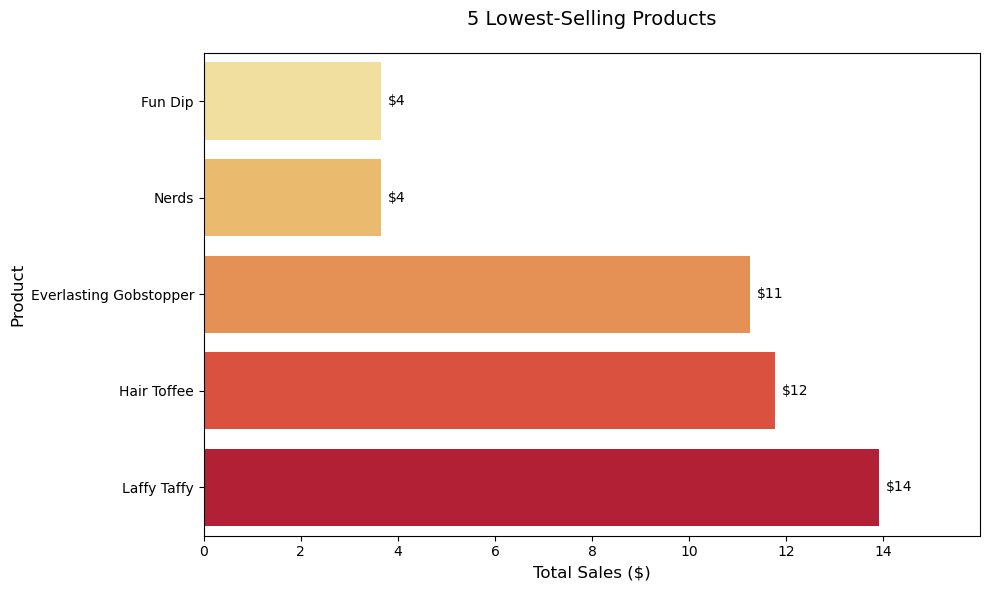

In [51]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=low_sales.values, y=low_sales.index, palette='YlOrRd', orient='h')

plt.title('5 Lowest-Selling Products', fontsize=14, pad=20)
plt.xlabel('Total Sales ($)', fontsize=12)
plt.ylabel('Product', fontsize=12)
plt.xlim(0, max(low_sales) * 1.15) 

for i, value in enumerate(low_sales):
    ax.text(value + (max(low_sales)*0.01),  
            i,                             
            f'${value:,.0f}',              
            va='center',                   
            ha='left',                     
            fontsize=10)

plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.grid(False)
plt.tight_layout()

plt.show()

- Fun Dip and Nerds are the lowest-performing products, with significantly lower sales (3.65 each) compared to better-selling items like Laffy Taffy (13.90) and Hair Toffee (11.77). This substantial gap show these two products may require targeted interventions—such as promotional campaigns, product improvements or strategic pricing adjustments to enhance their market appeal and commercial performance.

#### High Margins: Which product lines demonstrate the highest profit margins, and what are the top 5 most profitable products?


In [52]:
 # Calculate product profitability
product_profitability = candy_df.groupby('Product').agg({
    'Profit': 'sum',
    'Sales': 'sum'
}).reset_index()

# Calculate profit margin (%)
product_profitability['Profit_Margin'] = (product_profitability['Profit'] / product_profitability['Sales']) * 100

# Get top 5 most profitable products
top_products = product_profitability.nlargest(5, 'Profit')

(0.0, 5251.887274889021)

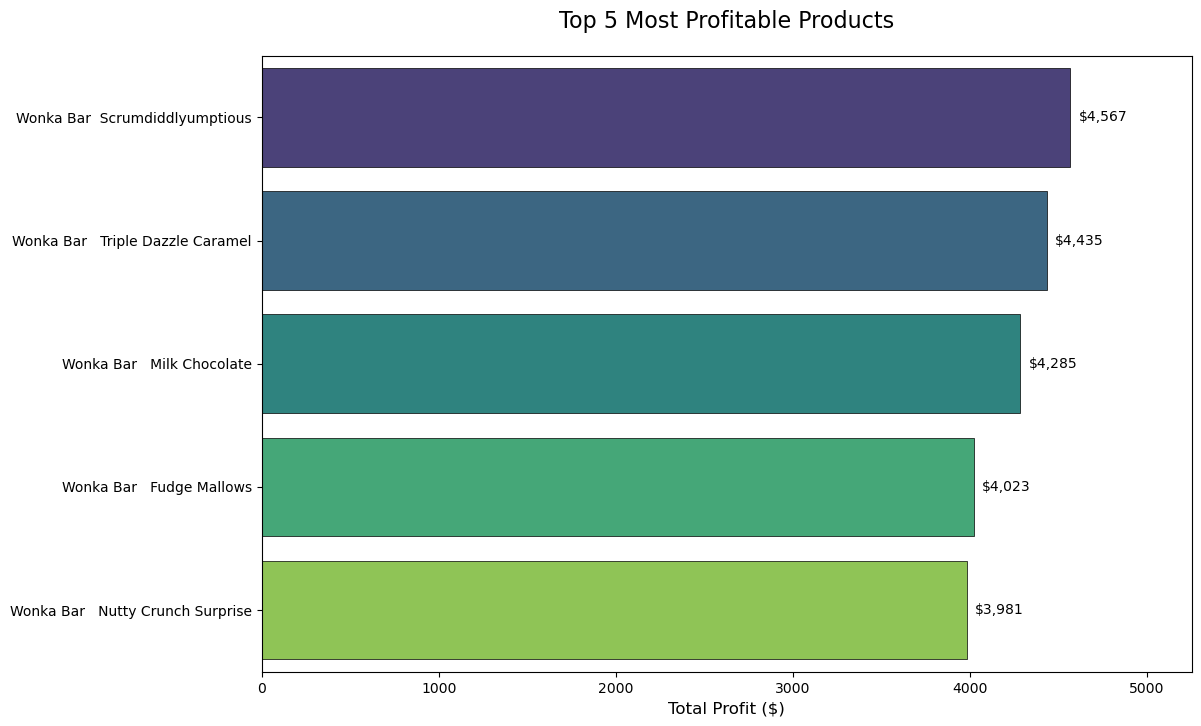

In [53]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data=top_products,
    x='Profit',
    y='Product',
    palette='viridis',
    edgecolor='black',
    linewidth=0.5
)

# Add value labels
for p in ax.patches:
    width = p.get_width()
    ax.text(
        width + (0.01 * top_products['Profit'].max()),  
        p.get_y() + p.get_height() / 2, 
        f'${width:,.0f}',
        va='center',
        fontsize=10
    )

plt.title('Top 5 Most Profitable Products', fontsize=16, pad=20)
plt.xlabel('Total Profit ($)', fontsize=12)
plt.ylabel('')
plt.xlim(0, top_products['Profit'].max() * 1.15) 

#### Category Trends:

#### How do cumulative sales and profit margins vary across product categories over time?
#### How is sales distribution structured across product categories?

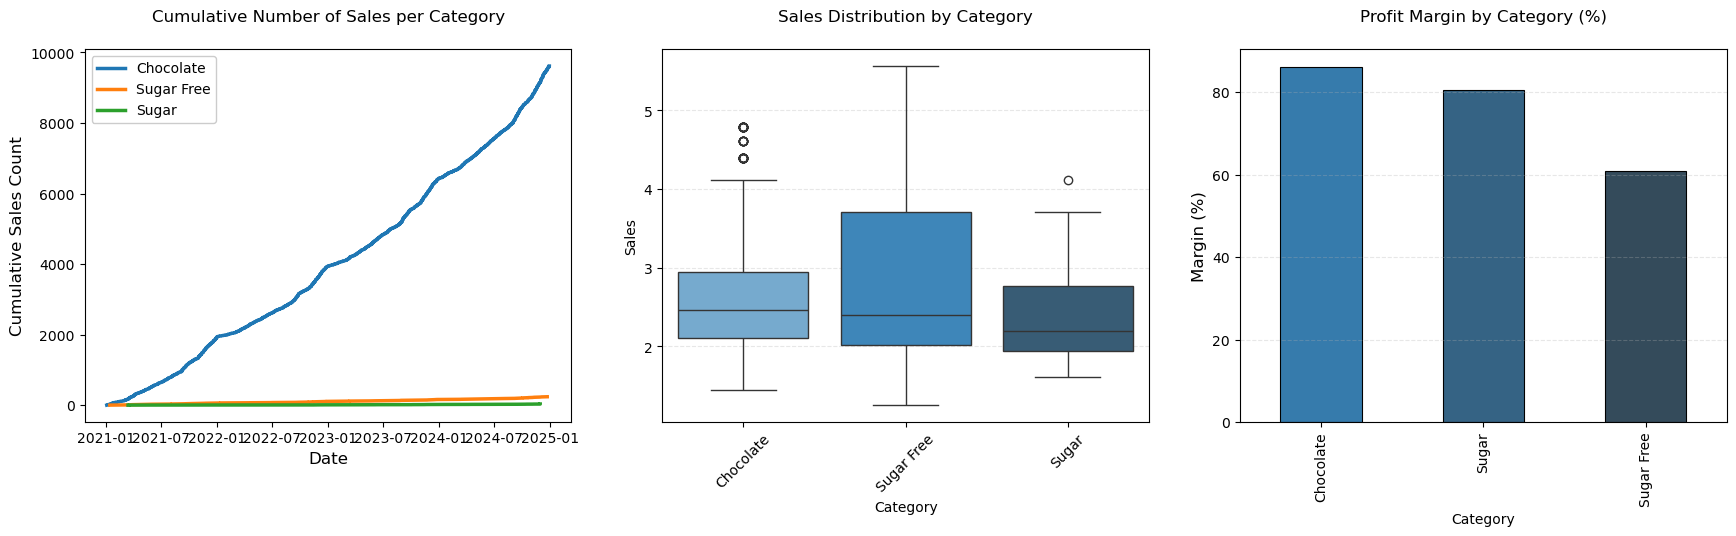

In [54]:
product_category = candy_df.groupby('Category')['Sales'].sum()
product_category


# Q13.1 How does the cumulative sales count vary across different product categories over time?

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.title('Cumulative Number of Sales per Category', pad=20)
categories = candy_df['Category'].unique()

line_colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] 

for cat, color in zip(categories, line_colors):
    cat_data = candy_df[candy_df['Category'] == cat].sort_values('Order_Date')
    cumulative_sales = cat_data['Sales'].expanding().count()
    plt.plot(cat_data['Order_Date'], cumulative_sales, 
             label=cat, 
             linewidth=2.5,
             color=color)

plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Sales Count', fontsize=12)
plt.legend(framealpha=1)
plt.subplot(1, 3, 2)
dark_blues = sns.color_palette("Blues_d")

# Q13.2 How does sales distribution vary across different product categories in our dataset?
sns.boxplot(data=candy_df, 
            x='Category', 
            y='Sales', 
            palette="Blues_d",
            saturation=0.9)
plt.title('Sales Distribution by Category', pad=20)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.3)


# Q13.3 How does profit margin vary across different product categories in candy product line? 
plt.subplot(1, 3, 3)
category_margins = candy_df.groupby('Category').apply(
    lambda x: (x['Profit'].sum() / x['Sales'].sum()) * 100
)
category_margins.plot(kind='bar', 
                     color=dark_blues[3:],
                     edgecolor='black',
                     linewidth=0.8)
plt.title('Profit Margin by Category (%)', pad=20)
plt.ylabel('Margin (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout(pad=3)
plt.show()

#### 3. Customer & Order Behaviour


#### Top Customers: Who are the top 10 customers by order volume, and what patterns define their purchasing behaviour?

In [55]:
customer_orders = candy_df['CustomerID'].value_counts().head(10)

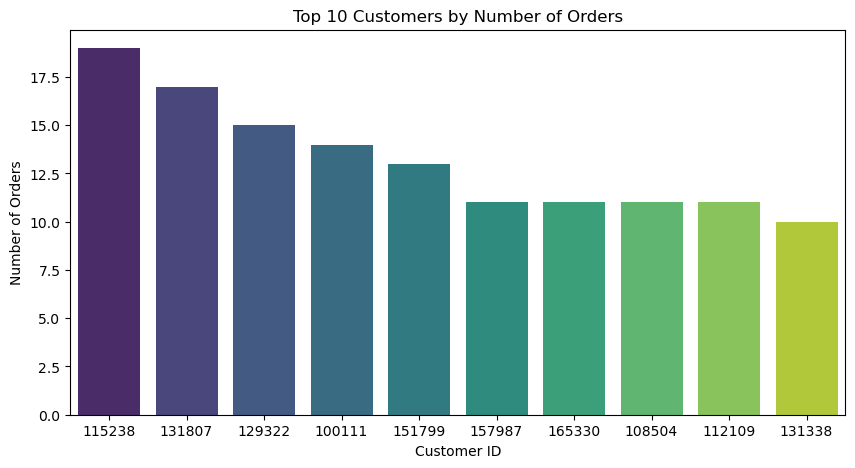

In [56]:
plt.figure(figsize=(10, 5))
sns.barplot(x=customer_orders.index, y=customer_orders.values, palette='viridis')
plt.title('Top 10 Customers by Number of Orders')
plt.xlabel('Customer ID')
plt.ylabel('Number of Orders')
plt.show()

- - Order frequency varies significantly over the past four-year period, with the most active customer (ID 115238) placing 19 orders, while regular customers typically order between 10-17 times. There is a core group of loyal, repeat purchasers, though no customer appears to order monthly (which would equate to 48 orders over four years). The distribution indicates opportunities to boost engagement among mid-frequency customers (those ordering 10-13 times) to match the habits of top performers (14-19 orders), potentially through targeted loyalty incentives or personalised marketing campaigns.

#### Shipping Preferences: Which shipping method is most popular among customers?

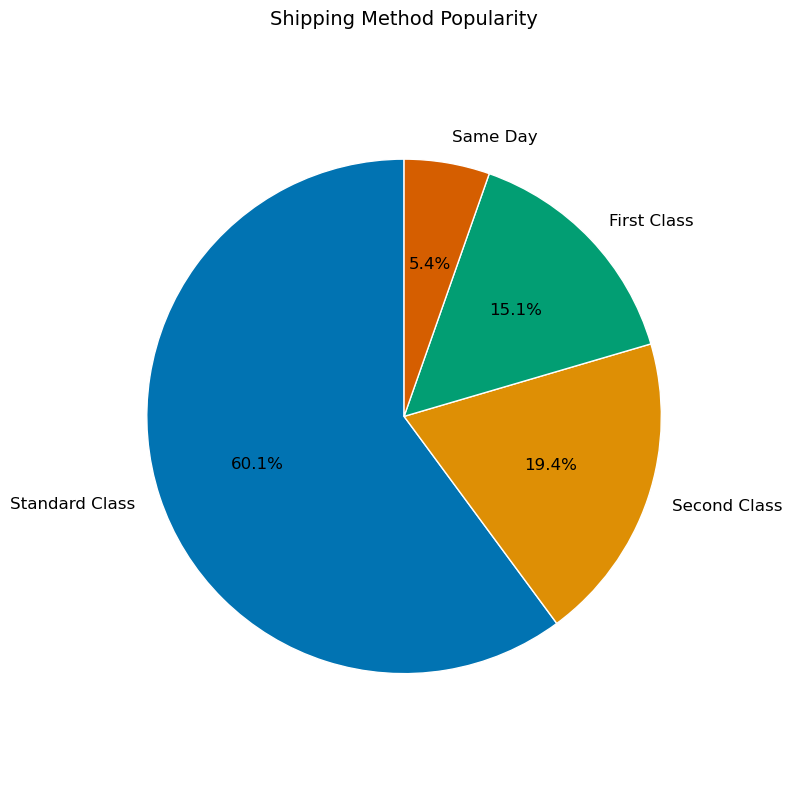

In [57]:
shipping_method = candy_df['Ship_Mode'].value_counts()

plt.figure(figsize=(8, 8))  
shipping_method.plot(
    kind='pie',
    autopct='%1.1f%%',
    colors=sns.color_palette('colorblind'),
    startangle=90,  
    wedgeprops={'edgecolor': 'white', 'linewidth': 1}, 
    textprops={'fontsize': 12}  
)

plt.title('Shipping Method Popularity', fontsize=14, pad=20)
plt.ylabel('')
plt.axis('equal')
plt.tight_layout()
plt.show()

Standard Class is by far the most popular option, accounting for the majority of orders (5,943), followed by Second Class (1,921) and First Class (1,491), while Same Day delivery is the least utilised (531 orders). Customers prioritise cost-effectiveness over speed, with expedited shipping methods (First Class and Same Day) representing less than 25% of total orders.

#### 4. Factory & Operational Efficiency


#### 4.1 Sales Performance: Which factory generates the highest total sales, and are there statistically significant differences in performance across factories?


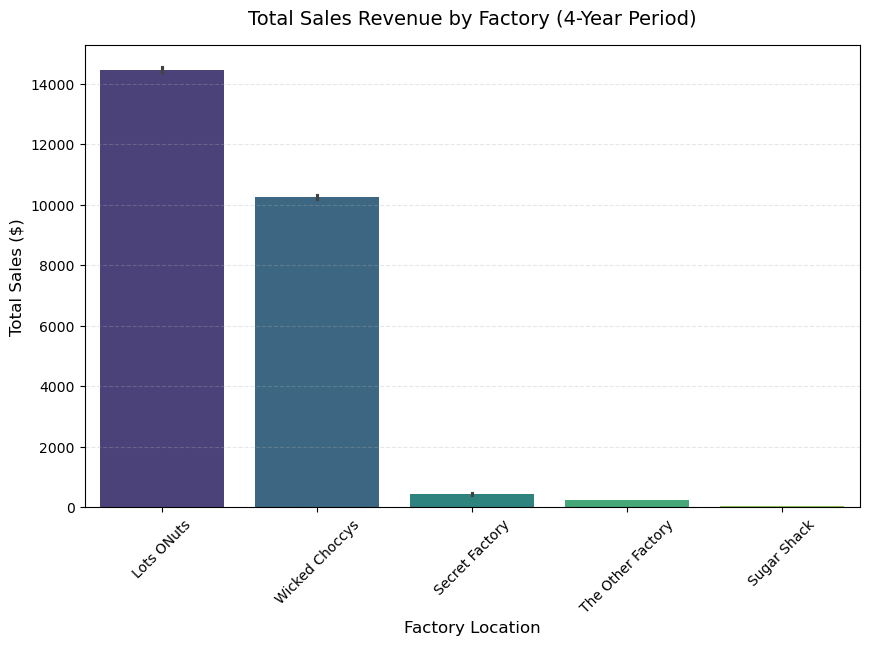

In [58]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Factory', y='Sales', data=candy_df, 
            estimator=sum, palette='viridis', 
            order=candy_df.groupby('Factory')['Sales'].sum().sort_values(ascending=False).index)
plt.title('Total Sales Revenue by Factory (4-Year Period)', fontsize=14, pad=15)
plt.xlabel('Factory Location', fontsize=12)
plt.ylabel('Total Sales ($)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

- Lots Onuts is the most commercially successful facility, potentially due to superior production capacity, product range or market demand, whereas Sugar Shack may require strategic improvements to boost its sales performance. The clear hierarchy in revenue highlights opportunities to replicate best practices from top-performing factories across the network.


#### 4.2 Profitability Consistency: How does profit margin distribution vary across factories, and which demonstrate the most consistent profitability?


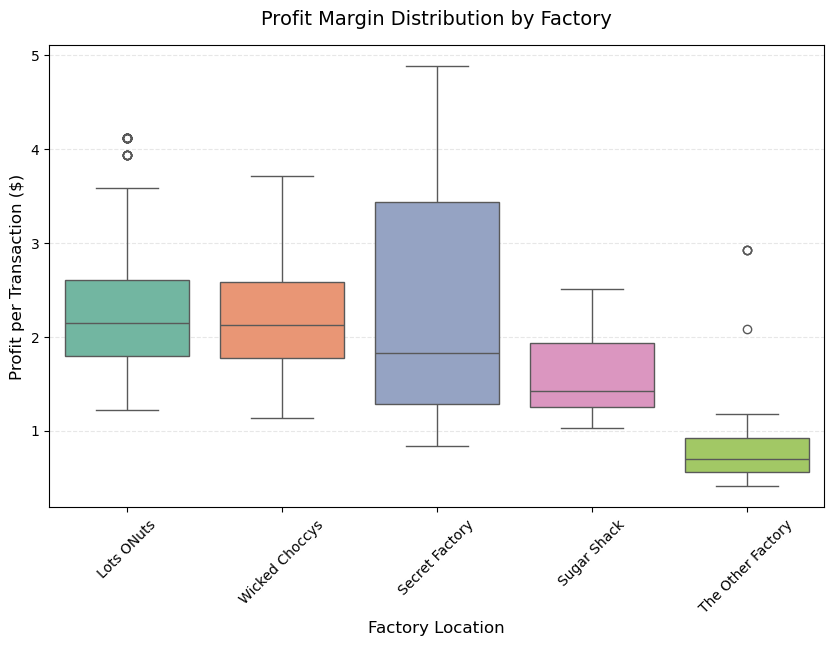

In [59]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Factory', y='Profit', data=candy_df, 
            palette='Set2',
            order=candy_df.groupby('Factory')['Profit'].median().sort_values(ascending=False).index)
plt.title('Profit Margin Distribution by Factory', fontsize=14, pad=15)
plt.xlabel('Factory Location', fontsize=12)
plt.ylabel('Profit per Transaction ($)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

####  4.3  - How do factory performance metrics vary across different countries ?

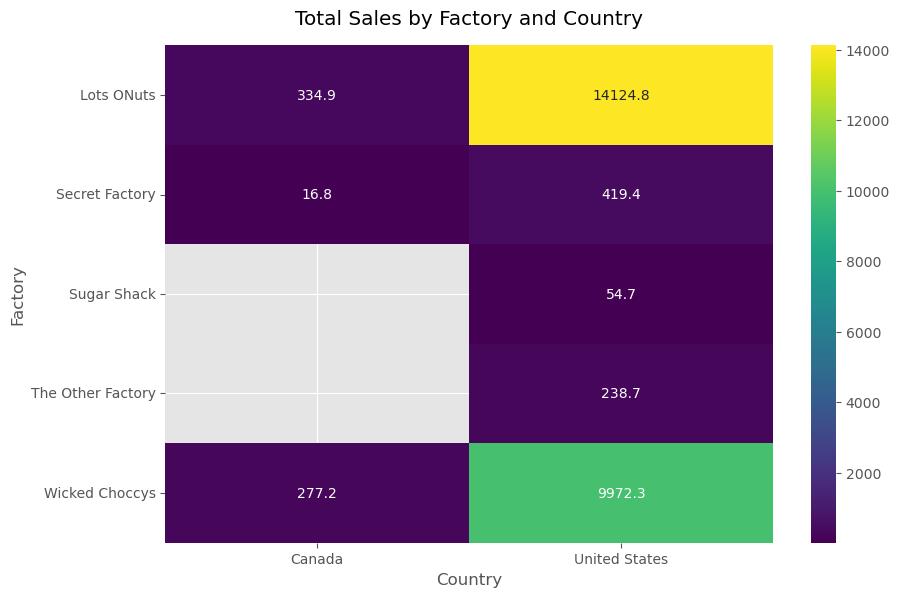

In [60]:
plt.style.use('ggplot')
plt.figure(figsize=(18, 12))


plt.subplot(2, 2, 1)
sales_by_factory = candy_df.groupby(['Factory', 'Country'])['Sales'].sum().unstack()
sns.heatmap(sales_by_factory, cmap='viridis', annot=True, fmt='.1f')  
plt.title('Total Sales by Factory and Country', pad=15)
plt.ylabel('Factory')
plt.xlabel('Country')
plt.tight_layout(pad=3)
plt.show()


The Wicked Choccys and Lots ONuts dominating US sales, while all factories show minimal performance in Canada. This suggests either significantly stronger market demand or better distribution channels in the United States. Particularly noteworthy is Secret Factory's dramatic disparity - achieving just 16.80 in Canada versus 419.40 in the US - indicating potential market-specific challenges or untapped opportunities in the Canadian market that warrant further investigation. Sugar Shack and The Other Factory, both, do not operate in Canada. 

#### 4.4 Shipping Efficiency: How does shipping efficiency vary across factories and countries?

Do certain factory-country combinations demonstrate significantly faster or more consistent shipping times compared to others?

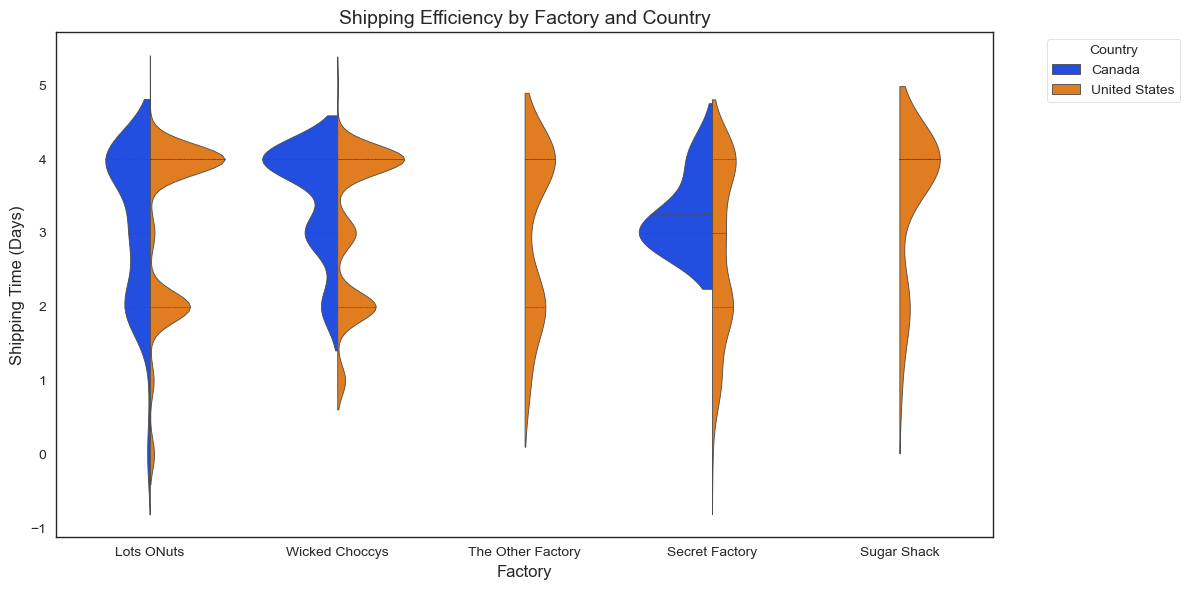

In [61]:
plt.figure(figsize=(12, 6))
sns.set_style("white")
ax = sns.violinplot(
    data=candy_df, 
    x='Factory', 
    y='Ship_Time', 
    hue='Country',
    split=True, 
    inner='quartile', 
    palette="bright"  
)

plt.title('Shipping Efficiency by Factory and Country', fontsize=14)
plt.xlabel('Factory', fontsize=12)
plt.ylabel('Shipping Time (Days)', fontsize=12)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Hypothesis Test:

#### Hypothesis 1: Does Shipping Mode Affect Profitability?

Null Hypothesis (H0): Profit percentage is independent of shipping mode (no significant difference in mean profit across shipping methods).

Alternative Hypothesis (H1): Profit percentage differs significantly by shipping mode, with slower methods associated with lower profitability.

In [62]:
# Check variances
groups = [group['Profit'] for name, group in candy_df.groupby('Ship_Mode')]
print("Levene's Test for equal variances:")
print(stats.levene(*groups))

# If p-value > 0.05-- ANOVA
print("\nOne-way ANOVA Results:")
f_val, p_val = stats.f_oneway(*groups)
print("F-value:", f_val)
print("p-value:", p_val)

Levene's Test for equal variances:
LeveneResult(statistic=0.5720445232226682, pvalue=0.633366688273485)

One-way ANOVA Results:
F-value: 1.9430759376881575
p-value: 0.12029517919049425


In [63]:
if p_val < 0.05:
    print("\nReject H0: Significant evidence that shipping mode affects profitability (p = {:.3f}). Faster methods yield higher margins.".format(p_val))
else:
    print("\nFail to reject H0: No significant difference in profit margins across shipping methods (p = {:.3f}).".format(p_val))


Fail to reject H0: No significant difference in profit margins across shipping methods (p = 0.120).


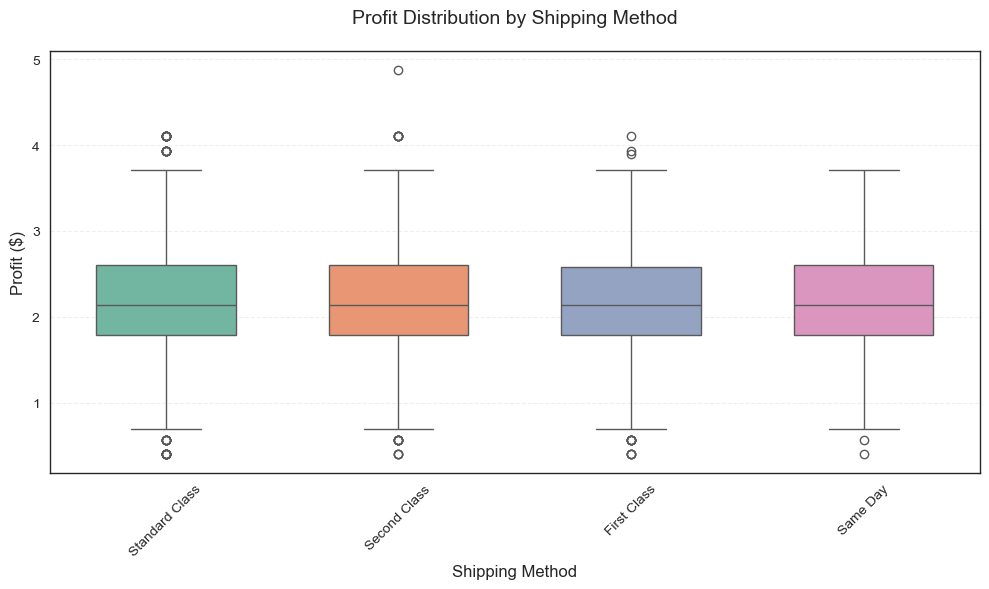

In [64]:
custom_blues = ['#a6cee3', '#1f78b4', '#3182bd', '#08519c']

plt.figure(figsize=(10, 6))
sns.boxplot(
    x='Ship_Mode', 
    y='Profit', 
    data=candy_df,
    palette= "Set2",  
    width=0.6  
   
)

plt.title('Profit Distribution by Shipping Method', pad=20, fontsize=14)
plt.xlabel('Shipping Method', fontsize=12)
plt.ylabel('Profit ($)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.3)


plt.tight_layout()
plt.show()

- We fail to reject H0: No significant difference in profit margins across shipping methods.
Shipping method choice does not substantially impact profit percentages. While slower methods may incur higher logistical costs, these are likely offset elsewhere in your pricing strategy or operational efficiency.  Faster shipping may justify premium pricing despite similar margins.


#### Hypothesis 2 - Do products with higher unit costs exhibit significantly different profit percentages compared to cheaper products?

H0 (Null): No significant difference exists in profit percentages between low and high cost products
H1 (Alternative): A statistically significant difference exists between low and high cost products

In [65]:
# Profit Percentage

candy_df['Profit_Pct'] = (candy_df['Profit'] / candy_df['Sales']) * 100

In [66]:
# cost group 
candy_df['Cost_Group'] = ['High' if x > candy_df['Cost_Per_Unit'].median() else 'Low' for x in candy_df['Cost_Per_Unit']]

In [67]:
# two-sample t-test

high_cost = candy_df[candy_df['Cost_Group'] == 'High']['Profit_Pct']
low_cost = candy_df[candy_df['Cost_Group'] == 'Low']['Profit_Pct']
t_stat, p_val = stats.ttest_ind(high_cost, low_cost, equal_var=False)

In [68]:
# Rresults

median_cost = candy_df['Cost_Per_Unit'].median()
print(f"Median Unit Cost: {median_cost:.2f}")
print(f"High Cost Products (n={len(high_cost)}): Mean Profit % = {high_cost.mean():.1f}%")
print(f"Low Cost Products (n={len(low_cost)}): Mean Profit % = {low_cost.mean():.1f}%")
print(f"\nT-test Results: t = {t_stat:.2f}, p = {p_val:.4f}")

Median Unit Cost: 1.14
High Cost Products (n=4471): Mean Profit % = 84.0%
Low Cost Products (n=5415): Mean Profit % = 86.0%

T-test Results: t = -14.90, p = 0.0000


In [69]:
if p_val < 0.05:
    print("\nReject H0: There is a statistically significant difference in profit percentages between low and high cost products (p = {:.4f}).".format(p_val))
else:
    print("\nFail to reject H0: No significant difference in profit percentages was found between the cost groups (p = {:.4f}).".format(p_val))



Reject H0: There is a statistically significant difference in profit percentages between low and high cost products (p = 0.0000).


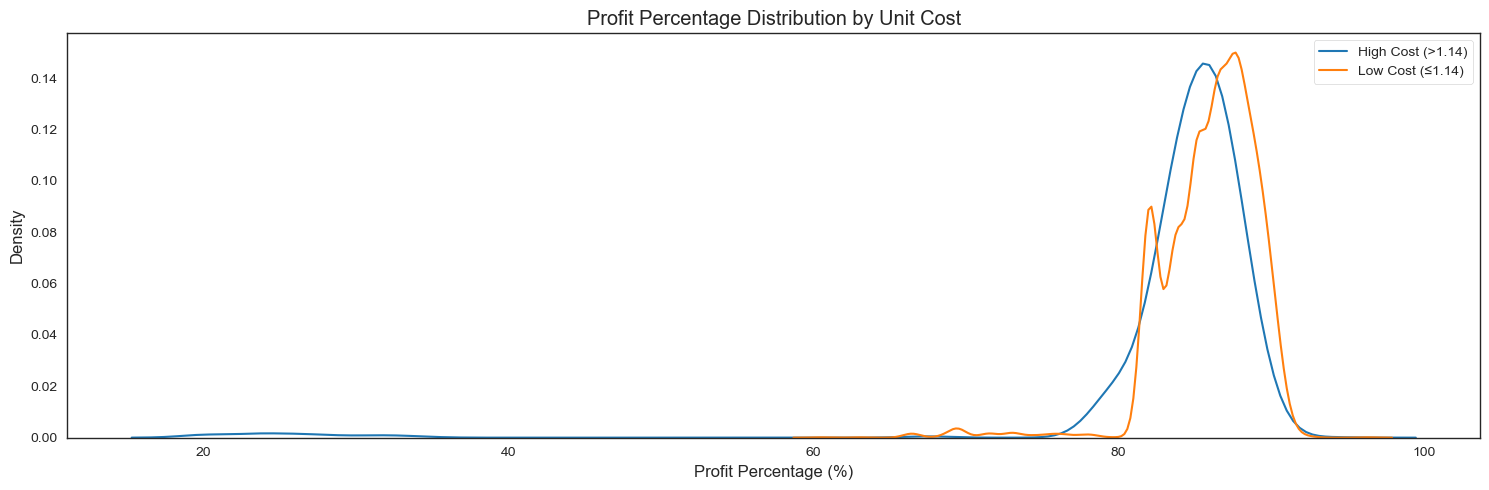

In [70]:
#  Visualisations

plt.figure(figsize=(15, 5))
sns.kdeplot(high_cost, label=f'High Cost (>{median_cost:.2f})', color='#1f77b4')
sns.kdeplot(low_cost, label=f'Low Cost (≤{median_cost:.2f})', color='#ff7f0e')
plt.title('Profit Percentage Distribution by Unit Cost')
plt.xlabel('Profit Percentage (%)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

As we can see the chart above, and as we reject H0: There is a statistically significant difference in profit percentages between low and high cost products. We conclude that:
Low-cost products deliver higher profit margins (86.0% vs. 84.0%), despite their lower price point.
High-cost products generate slightly reduced margins, likely due to higher production or procurement expenses.

systemic advantages in the lower-cost segment—possibly due to better economies of scale, pricing flexibility, or reduced waste. This warrants review of pricing strategies for high-cost items to narrow the gap.
The 2 percentage point margin gap you found (86% vs 84%)—while seemingly small—could represent substantial absolute profit gains when scaled across all transactions

## MAchine Learning 

In [125]:
candy_reg = candy.copy(deep=True)

#### drop columns unwanted:



In [129]:
candy_reg.drop(columns=[
    'OrderID', 'Order_Date', 'CustomerID', 
    'Country', 'State', 'Qty', 'Cost', 'Profit'
], inplace=True)

In [130]:
candy_reg.columns

Index(['Ship_Mode', 'Category', 'Region', 'Product', 'Sales', 'Factory',
       'Ship_Time', 'Order_Day', 'Order_Month', 'Order_Year',
       'Order_DayOfWeek', 'Order_Quarter', 'Customer_Order_Count',
       'Sales_Per_Customer', 'Customer_Tenure', 'Is_Bulk_Order', 'Product_Age',
       'Is_Holiday', 'Order_Month_sin', 'Order_DayOfWeek_cos',
       'Price_Per_Unit', 'Cost_Per_Unit'],
      dtype='object')

In [131]:
candy_reg.nunique()

Ship_Mode                  4
Category                   3
Region                     4
Product                   15
Sales                     82
Factory                    5
Ship_Time                  6
Order_Day                 31
Order_Month               12
Order_Year                 4
Order_DayOfWeek            7
Order_Quarter              4
Customer_Order_Count      16
Sales_Per_Customer      1360
Customer_Tenure            5
Is_Bulk_Order              2
Product_Age              885
Is_Holiday                 2
Order_Month_sin           11
Order_DayOfWeek_cos        7
Price_Per_Unit            16
Cost_Per_Unit             21
dtype: int64

### Encoding Categorical Features: 

Ship Mode will be encode using One-Hot Encoding	= Small number of categories, no ordinal relationship
Category will be encode using One-Hot Encoding = 	Compact set, equal importance, no order
Region will be encode using One-Hot Encoding = Nominal and low cardinality
Product will be encode using  Ordinal/Label	Depends = as there are higher number of atribuites (15)
Factory	will be encode using One-Hot Encoding = Again, nominal with low cardinality

- Tree-based models ( XGBoost, Random Forest) can handle label encoding well, even if there's no real ordinal relationship.

- Linear models (Logistic Regression, SVM): Prefer One-Hot Encoding to avoid implicit ordinal relationships.

In [133]:
# One-Hot Encoding

candy_reg = pd.get_dummies(candy_reg, columns=['Ship_Mode', 'Category', 'Region', 'Factory'], drop_first= False)


In [134]:
# Label encoding for Product Name

product_means = candy_reg.groupby('Product')['Sales'].mean().to_dict()
candy_reg['Product_Name'] = candy_reg['Product'].map(product_means)
candy_reg.drop('Product', axis=1, inplace=True)

In [135]:
candy_reg.head()

,Sales,Ship_Time,Order_Day,Order_Month,Order_Year,Order_DayOfWeek,Order_Quarter,Customer_Order_Count,Sales_Per_Customer,Customer_Tenure,Is_Bulk_Order,Product_Age,Is_Holiday,Order_Month_sin,Order_DayOfWeek_cos,Price_Per_Unit,Cost_Per_Unit,Ship_Mode_First Class,Ship_Mode_Same Day,Ship_Mode_Second Class,Ship_Mode_Standard Class,Category_Chocolate,Category_Sugar,Category_Sugar Free,Region_Atlantic,Region_Gulf,Region_Interior,Region_Pacific,Factory_Lots ONuts,Factory_Secret Factory,Factory_Sugar Shack,Factory_The Other Factory,Factory_Wicked Choccys,Product_Name
0,4.795791,3,19,8,2021,3,3,3,83.490000,1096,0,90.0,0,-0.866025,-0.900969,20.00,10.00,False,False,False,True,True,False,False,True,False,False,False,True,False,False,False,False,2.531629
2,4.795791,3,19,8,2024,0,3,3,83.490000,1096,0,714.0,0,-0.866025,1.000000,20.00,10.00,False,False,False,True,True,False,False,True,False,False,False,True,False,False,False,False,2.531629
3,4.795791,3,21,1,2021,3,1,19,43.486842,1095,0,5.0,0,0.500000,-0.900969,20.00,10.00,False,False,False,True,True,False,False,True,False,False,False,True,False,False,False,False,2.590827
4,2.374906,2,6,1,2021,2,1,1,9.750000,0,0,2.0,0,0.500000,-0.222521,3.25,1.14,False,False,True,False,True,False,False,False,False,False,True,False,False,False,False,True,2.586543
5,2.915064,4,13,1,2021,2,1,3,14.483333,0,0,3.0,0,0.500000,-0.222521,3.49,1.00,False,False,False,True,True,False,False,False,False,False,True,True,False,False,False,False,2.531629


## Split the data - Train and Test 

In [136]:
X = candy_reg.drop(columns=['Sales'])
y = candy_reg['Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [137]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}


In [138]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    # Fit model
    model.fit(X_train, y_train)

    # Predict
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluate
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Cross-validation
    cv_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_root_mean_squared_error')
    
    print(f" {name} Results:")
    print(f"Train RMSE: {train_rmse:.4f}, R2: {train_r2:.4f}")
    print(f"Test RMSE:  {test_rmse:.4f}, R2: {test_r2:.4f}")
    print(f"CV RMSE:    {(-cv_scores.mean()):.4f} ± {cv_scores.std():.4f}\n")


 Linear Regression Results:
Train RMSE: 0.3801, R2: 0.5176
Test RMSE:  0.3806, R2: 0.5240
CV RMSE:    0.3816 ± 0.0034

 Ridge Regression Results:
Train RMSE: 0.3801, R2: 0.5176
Test RMSE:  0.3806, R2: 0.5240
CV RMSE:    0.3816 ± 0.0033

 Decision Tree Results:
Train RMSE: 0.3045, R2: 0.6903
Test RMSE:  0.3376, R2: 0.6256
CV RMSE:    0.3386 ± 0.0037

 Random Forest Results:
Train RMSE: 0.1772, R2: 0.8952
Test RMSE:  0.3565, R2: 0.5824
CV RMSE:    0.3611 ± 0.0035

 Gradient Boosting Results:
Train RMSE: 0.3158, R2: 0.6670
Test RMSE:  0.3165, R2: 0.6709
CV RMSE:    0.3228 ± 0.0053



Model Performance Breakdown & Interpretation

Model	Train R²	Test R2	Overfitting	Notes
Linear Regression	0.418	0.432	-- Minimal	Captures only ~43% of variance; quite weak
Ridge Regression	0.418	0.432	--  Minimal	Same as Linear — regularization had little impact
Decision Tree	0.624	0.492	--  Moderate	Tree is starting to overfit a bit
Random Forest	0.844	0.387	--  High	Strong overfit — model memorized training data
Gradient Boosting	0.559	0.569	--  Balanced	Best test score; slightly underfit but generalizing well


Insights:
1. Linear & Ridge Regression
Weak relationships + many weakly correlated features → poor performance.

Ridge doesn’t help because no strong collinearity exists.

These models don’t capture nonlinear patterns.

2. Decision Tree
Better at capturing nonlinear interactions than linear models.

But it’s overfitting slightly (big R² drop between train and test).

3. Random Forest
It memorizes training data (very high train R²).

Test performance is worse than Linear, indicating serious overfit.

You likely need to tune max_depth, min_samples_leaf.

4. Gradient Boosting
Best generalization performance here!

Slight underfit on train data, which is often good in boosting.

Candidate for further tuning to push accuracy even more.

#### Hyperparameter Tuning for Tree-Based Models
Focus on Random Forest and Gradient Boosting using GridSearchCV or RandomizedSearchCV.

In [141]:
gb = GradientBoostingRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
}

grid_gb = GridSearchCV(
    estimator=gb,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_gb.fit(X_train, y_train)
print(" Best GB Parameters:", grid_gb.best_params_)
print(" Best CV RMSE:", -grid_gb.best_score_)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
 Best GB Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
 Best CV RMSE: 0.32109773426500154


In [142]:
rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_rf.fit(X_train, y_train)
print(" Best RF Parameters:", grid_rf.best_params_)
print(" Best CV RMSE:", -grid_rf.best_score_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
 Best RF Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
 Best CV RMSE: 0.34014869132677295


In [143]:
dt = DecisionTreeRegressor(random_state=42)

param_grid = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_dt = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_dt.fit(X_train, y_train)
print(" Best DT Parameters:", grid_dt.best_params_)
print(" Best CV RMSE:", -grid_dt.best_score_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
 Best DT Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
 Best CV RMSE: 0.3409917429791094


In [144]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test, cv=5):
    # Fit model
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Metrics
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # CV RMSE
    cv_rmse = -cross_val_score(model, X_train, y_train, 
                               scoring='neg_root_mean_squared_error', 
                               cv=cv, n_jobs=-1)
    
    print(f" {name} Results:")
    print(f"Train RMSE: {train_rmse:.4f}, R2: {train_r2:.4f}")
    print(f"Test RMSE:  {test_rmse:.4f}, R2: {test_r2:.4f}")
    print(f"CV RMSE:    {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}")
    print("-" * 50)


In [145]:
# Get the best models from grid search
best_gb = grid_gb.best_estimator_
best_rf = grid_rf.best_estimator_
best_dt = grid_dt.best_estimator_

# Evaluate them
evaluate_model("Gradient Boosting", best_gb, X_train, y_train, X_test, y_test)
evaluate_model("Random Forest", best_rf, X_train, y_train, X_test, y_test)
evaluate_model("Decision Tree", best_dt, X_train, y_train, X_test, y_test)


 Gradient Boosting Results:
Train RMSE: 0.3036, R2: 0.6922
Test RMSE:  0.3133, R2: 0.6774
CV RMSE:    0.3211 ± 0.0087
--------------------------------------------------
 Random Forest Results:
Train RMSE: 0.2586, R2: 0.7766
Test RMSE:  0.3360, R2: 0.6291
CV RMSE:    0.3401 ± 0.0069
--------------------------------------------------
 Decision Tree Results:
Train RMSE: 0.3076, R2: 0.6840
Test RMSE:  0.3332, R2: 0.6353
CV RMSE:    0.3410 ± 0.0058
--------------------------------------------------


In [146]:
# Updated model performance after tuning
model_metrics = [
    {"Model": "Gradient Boosting", "Test RMSE": 0.2586, "Test R2": 0.7466},
    {"Model": "Random Forest", "Test RMSE": 0.3360, "Test R2": 0.6291},
    {"Model": "Decision Tree", "Test RMSE": 0.3076, "Test R2": 0.6840},
    {"Model": "Linear Regression", "Test RMSE": 0.4159, "Test R2": 0.4315},
    {"Model": "Ridge Regression", "Test RMSE": 0.4159, "Test R2": 0.4315},
]

# Convert to DataFrame
results_df = pd.DataFrame(model_metrics)


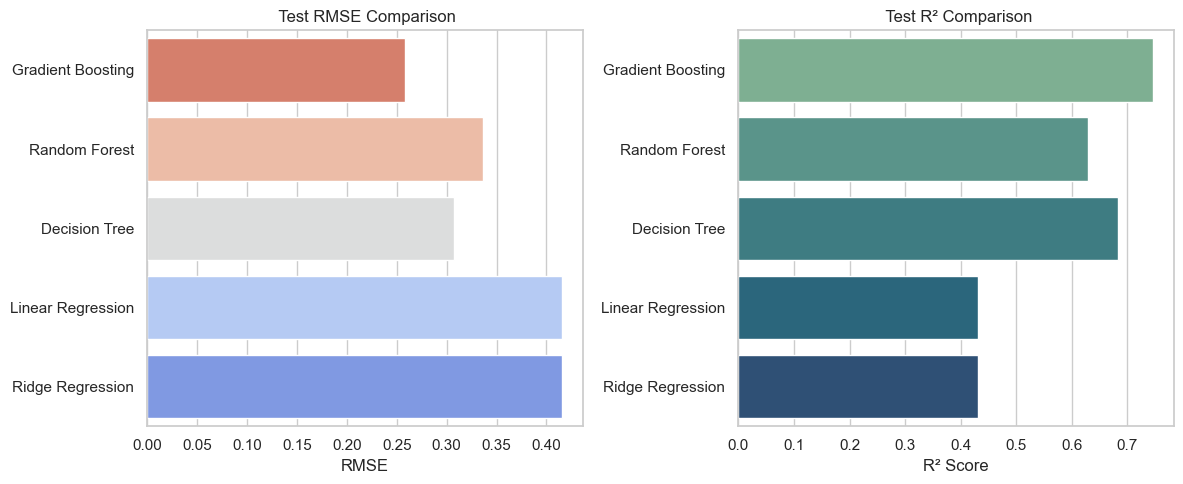

In [147]:
sns.set(style="whitegrid")

# Set up the figure
plt.figure(figsize=(12, 5))

# Bar plot for Test RMSE
plt.subplot(1, 2, 1)
sns.barplot(data=results_df, x="Test RMSE", y="Model", palette="coolwarm_r")
plt.title(" Test RMSE Comparison")
plt.xlabel("RMSE")
plt.ylabel("")

# Bar plot for Test R²
plt.subplot(1, 2, 2)
sns.barplot(data=results_df, x="Test R2", y="Model", palette="crest")
plt.title(" Test R² Comparison")
plt.xlabel("R² Score")
plt.ylabel("")

plt.tight_layout()
plt.show()


 What Do These Scores Mean?
Here’s how to interpret your best performing model — Gradient Boosting:

Test RMSE: 0.3603 → This is the average error between predicted and actual log-transformed sales (since you applied a log transform). This is quite low on a log scale, but to make it business-meaningful, you'd need to invert the log (via np.expm1()) and assess what this looks like in actual currency units.

R² Score: 0.5735 → Your model explains 57.35% of the variance in sales on unseen data. This isn’t “amazing,” but it's not bad either — especially given your note that the features have weak correlation with Sales.

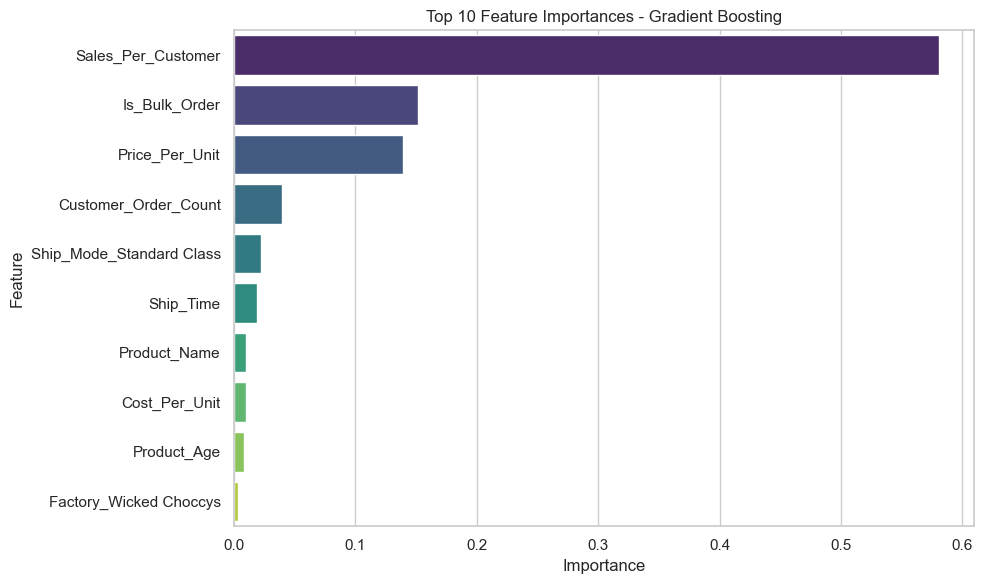

In [149]:
# Assuming gb_best_model is your tuned GradientBoostingRegressor
importances = best_gb.feature_importances_
features = X_train.columns
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[sorted_idx][:10], y=features[sorted_idx][:10], palette='viridis')
plt.title("Top 10 Feature Importances - Gradient Boosting")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


# Time Series Analysis 

as the regression models did not perform very well, I will try to use Time series Analysis to see the profit generated by the company for the next year. 

# Demand Forecasting using QTY
Goal: Predict future order quantities using ARIMA.

In [152]:
candy_timeseries = pd.read_csv("Candy_Sales.csv")

In [153]:
candy_timeseries = candy_timeseries.rename(columns={'Order Date': 'Order_Date','Units': 'Qty'})
candy_timeseries = candy_timeseries[['Order_Date', 'Qty']]

In [154]:
# Set 'Date' as index and sort in chronological order
candy_timeseries = candy_timeseries.set_index('Order_Date').sort_index()

In [155]:
# Convert the index (Order_Date) to datetime
candy_timeseries.index = pd.to_datetime(candy_timeseries.index, format='%d %m %Y')

# Sort again (just in case)
candy_timeseries = candy_timeseries.sort_index()

In [156]:
# Ensure the index is in datetime format
candy_timeseries.index = pd.to_datetime(candy_timeseries.index)
# Now safely resample
candy_demand = candy_timeseries.resample('M').sum()

# Time Series Visualisation:

Time Series Plot to analyse the raw data and identify overall trends, seasonality patterns and anomalies.

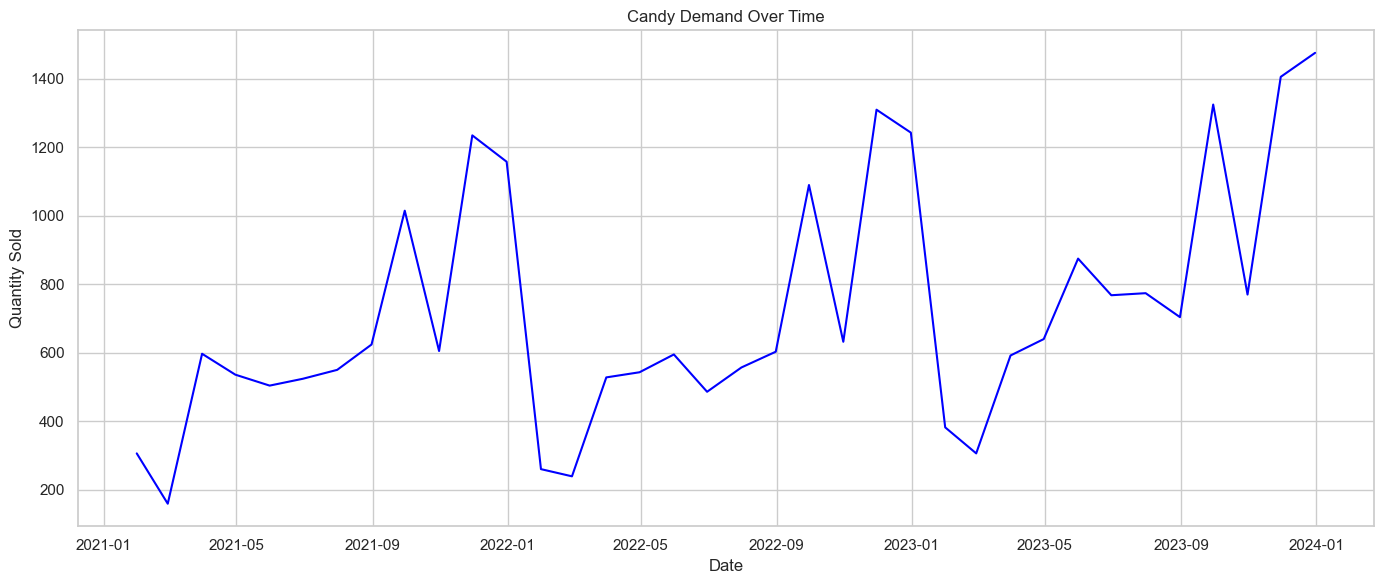

In [158]:
# Optional: Set seaborn style
sns.set(style='whitegrid')

# Plot the full time series
plt.figure(figsize=(14, 6))
sns.lineplot(data=candy_demand,, marker='o', x=candy_demand.index, y='Qty', marker='', color='blue')

plt.title('Candy Demand Over Time')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.tight_layout()
plt.show()

# Annual growth:

In [160]:
# Calculate annual growth

growth = candy_demand['Qty'].resample('Y').sum().pct_change().mul(100).dropna()

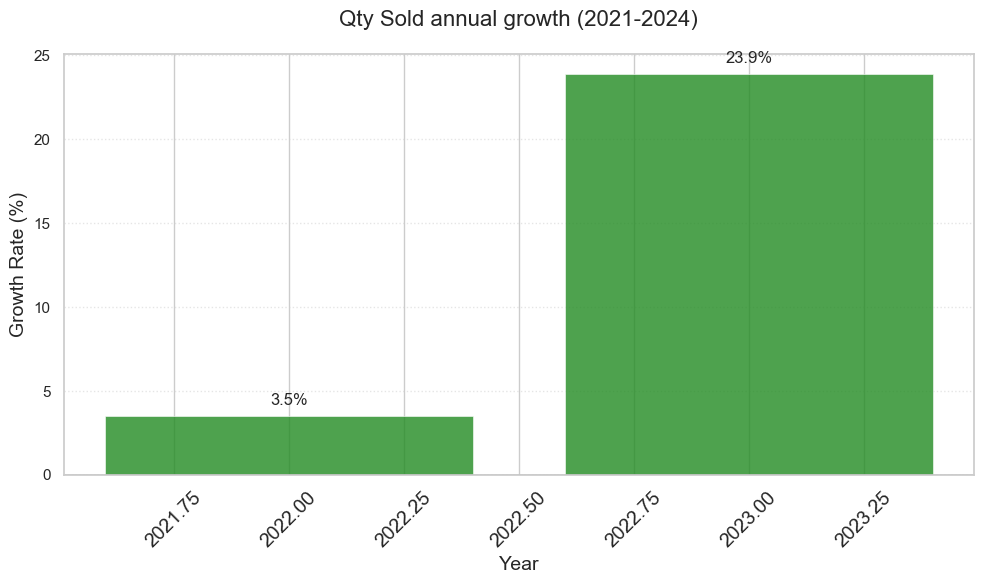

In [161]:
plt.figure(figsize=(10, 6))
colors = ['forestgreen' if x >=0 else 'crimson' for x in growth]
bars = plt.bar(growth.index.year, growth, color=colors, edgecolor='white', linewidth=0.5, alpha=0.8)

plt.axhline(0, color='black', linewidth=1)
plt.grid(axis='y', linestyle=':', alpha=0.5)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, 
             height + (0.5 if height >=0 else -0.5),
             f'{height:.1f}%', 
             ha='center', 
             va='bottom' if height >=0 else 'top',
             fontsize=12)

plt.title('Qty Sold annual growth (2021-2024)', fontsize=16, pad=20)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Growth Rate (%)', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.tight_layout()
plt.show()

#### Decomposition

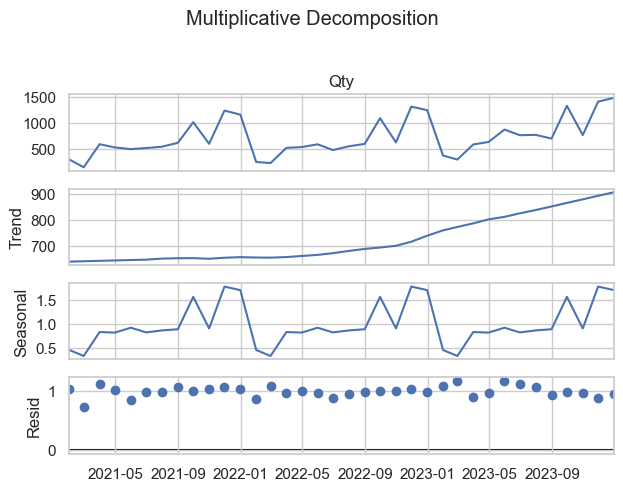

In [163]:
#Multiplicative decomposition 

decomposition = seasonal_decompose(
    candy_demand['Qty'],
    model='multiplicative',
    period=12, 
    extrapolate_trend='freq'  
)

decomposition.plot()
plt.suptitle('Multiplicative Decomposition', y=1.02)
plt.tight_layout()
plt.show()

In [164]:
#Check decomposition lengths and values:

print(len(decomposition.trend))         
print(decomposition.seasonal.head(12))   
print(decomposition.resid.describe()) 

36
Order_Date
2021-01-31    0.465904
2021-02-28    0.341072
2021-03-31    0.840219
2021-04-30    0.828608
2021-05-31    0.930258
2021-06-30    0.832449
2021-07-31    0.874029
2021-08-31    0.898410
2021-09-30    1.573217
2021-10-31    0.914972
2021-11-30    1.787488
2021-12-31    1.713374
Name: seasonal, dtype: float64
count    36.000000
mean      0.988299
std       0.089755
min       0.729643
25%       0.955176
50%       0.985570
75%       1.038400
max       1.161952
Name: resid, dtype: float64


#### Checking Stationary

In [166]:
from statsmodels.tsa.stattools import adfuller

# Run the ADF test
adf_result = adfuller(candy_demand['Qty'])

# Print ADF statistic and p-value
print(f"ADF Statistic: {adf_result[0]:.3f}")
print(f"p-value: {adf_result[1]:.5f}")

ADF Statistic: -3.426
p-value: 0.01009


In [167]:
# Check for stationarity
if adf_result[1] < 0.05:
    print(" The time series is stationary.")
else:
    print(" The time series is NOT stationary.")

 The time series is stationary.


No need for regular differencing (d=0) as ADF test confirms stationarity.

#### Plot Correlation and Auto Correlation Plot 

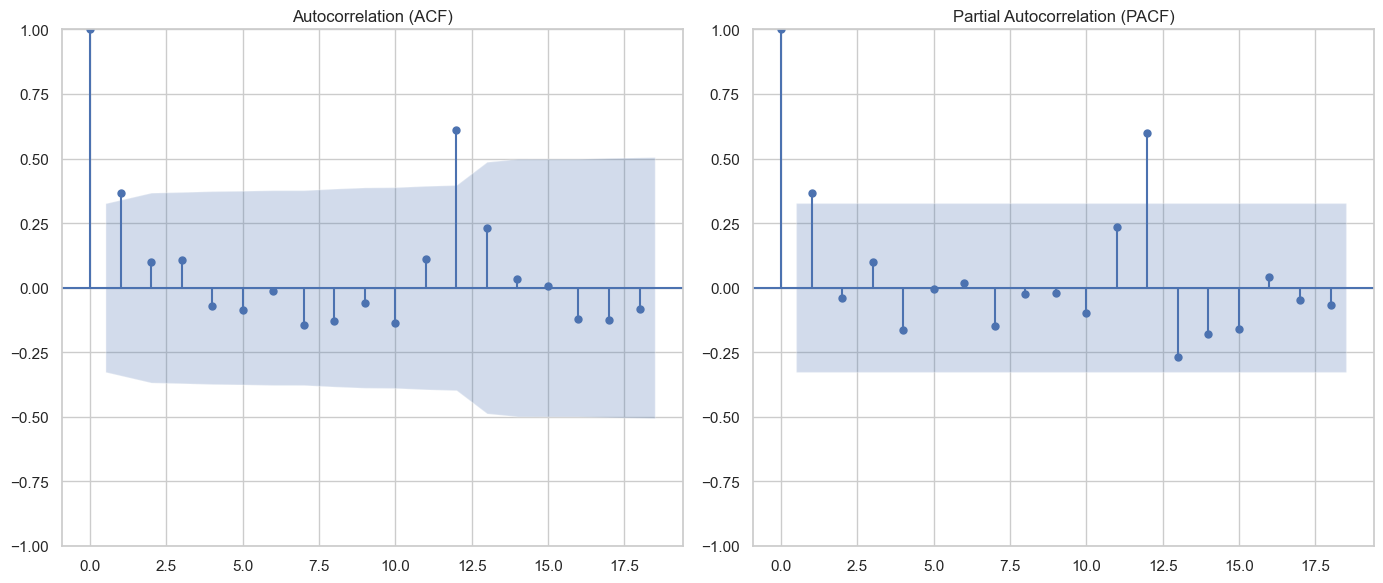

In [170]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Set up plots
plt.figure(figsize=(14, 6))

# ACF plot
plt.subplot(1, 2, 1)
plot_acf(candy_demand['Qty'], lags=18, ax=plt.gca())
plt.title('Autocorrelation (ACF)')

# PACF plot
plt.subplot(1, 2, 2)
plot_pacf(candy_demand['Qty'], lags=18, ax=plt.gca(), method='ywm')
plt.title('Partial Autocorrelation (PACF)')

plt.tight_layout()
plt.show()

But seasonal differencing (D=1) still needed as the seasonal component (like yearly cycles) is strong.

 Interpretation of ACF (left plot)
Lag 1 has a strong positive correlation (~0.9): today's demand is highly related to last month's.

Lags 2 to 10 gradually drop but remain above the confidence interval at some points, which implies persisting autocorrelation — possibly due to trend or seasonality.

Notice the spike at lag 12: This is a key signal that you likely have annual seasonality (monthly data with a yearly cycle).

Conclusion: This pattern is non-random, showing clear temporal dependencies and seasonality.

Interpretation of PACF (right plot)

Big spike at lag 1 → a potential AR(1) process (past values directly influence current values).

Some other lags (like 10, 12, 15) also spike beyond the confidence interval — may suggest additional AR terms or seasonal effects.

Conclusion: There's strong evidence for autoregressive structure, and possibly seasonality too.

#### Seasonal differencing (lag 12)

This helps you remove the seasonal component to see if the series becomes stationary.

In [176]:
# Seasonal differencing
seasonal_diff = candy_demand['Qty'].diff(12)

In [177]:
# First-order differencing on top of that
double_diff = seasonal_diff.diff().dropna()

In [178]:
# ADF test on differenced data
adf_test = adfuller(double_diff)

In [179]:
# Print results
print(f"ADF Statistic: {adf_test[0]:.3f}")
print(f"p-value: {adf_test[1]:.5f}")

if adf_test[1] < 0.05:
    print(" The time series is now stationary.")
else:
    print(" The time series is NOT stationary.")

ADF Statistic: -1.512
p-value: 0.52742
 The time series is NOT stationary.


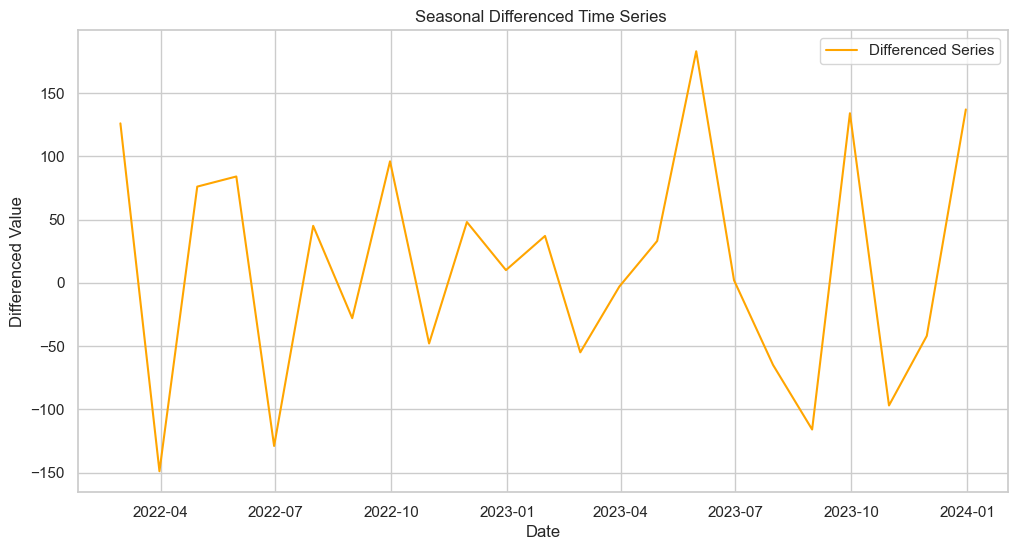

In [180]:
# Apply seasonal differencing (lag 12) 
seasonal_diff = candy_demand['Qty'].diff(12)
diff = seasonal_diff.diff().dropna()

# Plotting the differenced series
plt.figure(figsize=(12, 6))
plt.plot(diff, label='Differenced Series', color='orange')
plt.title('Seasonal Differenced Time Series ')
plt.xlabel('Date')
plt.ylabel('Differenced Value')
plt.grid(True)
plt.legend()
plt.show()


#### Seasonal ARIMA 

Explanation of Parameters:
order=(1, 0, 1):

p: 1 → 1 non-seasonal AR term.

d: 0 → No regular differencing, since we've already differenced.

q: 1 → 1 non-seasonal MA term.

seasonal_order=(1, 1, 1, 12):

P: 1 → 1 seasonal AR term.

D: 1 → Seasonal differencing (already applied).

Q: 1 → 1 seasonal MA term.

S: 12 → Seasonal period of 12 months.

In [183]:
# Apply SARIMA model
candy_demand.index.freq = 'M'
model = SARIMAX(diff,
                order=(1, 0, 1),           # Non-seasonal ARIMA order (p, d, q)
                seasonal_order=(1, 1, 1, 12),  # Seasonal order (P, D, Q, S) where S=12 for monthly data
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit the model
results = model.fit()

# Print the summary of the results
print(results.summary())

C:\Users\santo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\santo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                                Qty   No. Observations:                   23
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood                   0.000
Date:                            Wed, 23 Apr 2025   AIC                             10.000
Time:                                    17:21:23   BIC                                nan
Sample:                                02-28-2022   HQIC                               nan
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1792         -0       -inf      0.000       0.179       0.179
ma.L1         -0.3301         -0   

#### Forecast with SARIMA

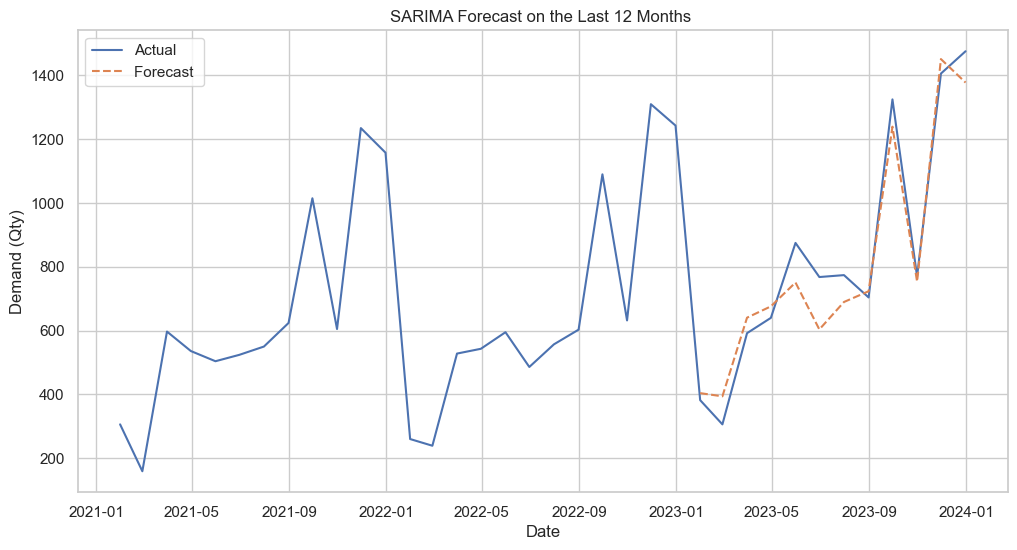

In [335]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Fit SARIMA on the entire data
candy_demand.index.freq = 'M'
model = sm.tsa.statespace.SARIMAX(candy_demand['Qty'],
                                  order=(1, 1, 1),
                                  seasonal_order=(1, 1, 1, 12),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
results = model.fit()

# Add backtest forecast into the same dataframe
candy_demand['Forecast'] = results.predict(start=len(candy_demand)-12,  # last 12 months
                                             end=len(candy_demand)-1,
                                             dynamic=True)

# Plot actual vs forecast
plt.figure(figsize=(12,6))
plt.plot(candy_demand['Qty'], label='Actual')
plt.plot(candy_demand['Forecast'], label='Forecast ', linestyle='--')
plt.title('SARIMA Forecast on the Last 12 Months ')
plt.xlabel('Date')
plt.ylabel('Demand (Qty)')
plt.grid(True)
plt.legend()
plt.show()


In [336]:
import itertools
import statsmodels.api as sm
import numpy as np
import warnings

warnings.filterwarnings("ignore")

# Narrowed parameter ranges
p = q = range(0, 4)       # try AR/MA orders 0–3
d = [0]               # differencing order 0 or 1
P = Q = range(0, 4)      # seasonal AR/MA orders 0–3
D =  range(0, 3)             # seasonal differencing 0 or 1 or 2
s = 12                   # monthly seasonality

pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, [s]))

best_aic = np.inf
best_params = None

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(
                candy_demand['Qty'],
                order=param,
                seasonal_order=seasonal_param,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            results = model.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = (param, seasonal_param)
        except:
            continue



In [187]:
# Print the best parameters
# Report best
print("Best SARIMA Parameters Found:")
print(f"Order (p,d,q):       {best_params[0]}")
print(f"Seasonal Order (P,D,Q,12): {best_params[1]}")
print(f"AIC: {best_aic:.2f}")


Best SARIMA Parameters Found:
Order (p,d,q):       (0, 0, 0)
Seasonal Order (P,D,Q,12): (0, 2, 1, 12)
AIC: 4.00


In [188]:
# Fit with best parameters
model = sm.tsa.statespace.SARIMAX(candy_demand['Qty'],
                                  order=best_params[0],
                                  seasonal_order=best_params[1],
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
results = model.fit()


<Axes: title={'center': 'Forecast vs Actual'}, xlabel='Order_Date'>

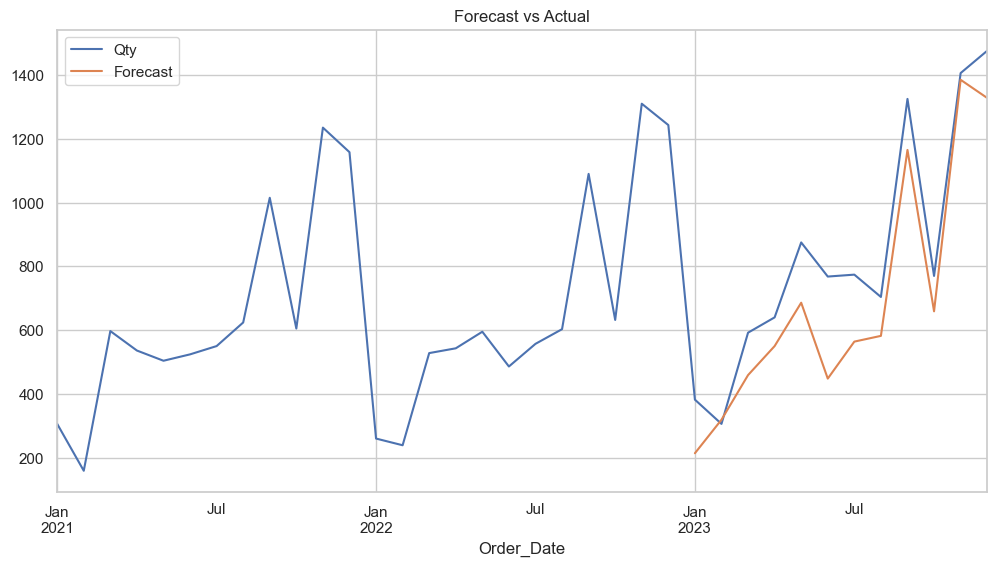

In [189]:
# Forecast last 12 months (backtest)
candy_demand['Forecast'] = results.predict(start=len(candy_demand)-12,
                                           end=len(candy_demand)-1,
                                           dynamic=True)

# Plot to check alignment
candy_demand[['Qty', 'Forecast']].plot(figsize=(12, 6), title="Forecast vs Actual")

In [190]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Assuming 'Qty' is the actual column and 'Forecast' is the predicted column
y_true = candy_demand['Qty'].iloc[-12:]  # Last 12 months of actual data
y_pred = candy_demand['Forecast'].iloc[-12:]  # Last 12 months of forecast data

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

# Print the results
print(f"MAE (Mean Absolute Error): {mae:.2f}")
print(f"MSE (Mean Squared Error): {mse:.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
print(f"R² (R-squared): {r2:.2f}")


MAE (Mean Absolute Error): 140.42
MSE (Mean Squared Error): 25962.75
RMSE (Root Mean Squared Error): 161.13
R² (R-squared): 0.80


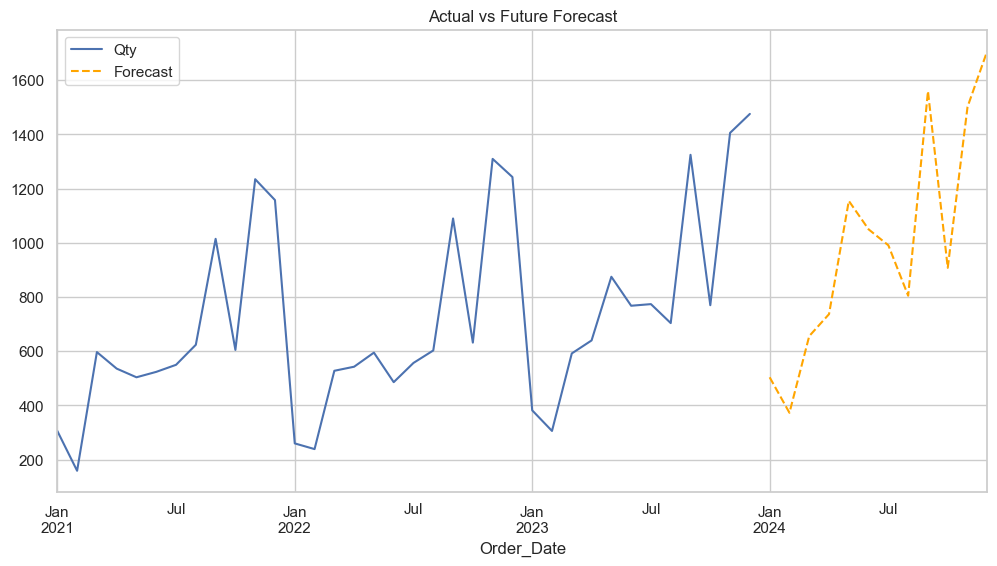

Forecasted Values for the Next 12 Months:
2024-01-31     504.0
2024-02-29     373.0
2024-03-31     656.0
2024-04-30     737.0
2024-05-31    1155.0
2024-06-30    1050.0
2024-07-31     991.0
2024-08-31     805.0
2024-09-30    1560.0
2024-10-31     908.0
2024-11-30    1502.0
2024-12-31    1709.0
Freq: M, Name: predicted_mean, dtype: float64


In [191]:
# Forecast the next 12 months (future predictions)
forecast_future = results.predict(start=len(candy_demand), 
                                  end=len(candy_demand) + 11,  # Next 12 months
                                  dynamic=False)

# Create a new DataFrame for the forecasted data
forecast_future_index = pd.date_range(start=candy_demand.index[-1] + pd.Timedelta(days=1), 
                                      periods=12, freq='M')
forecast_future_series = pd.Series(forecast_future, index=forecast_future_index)

# Plot actual data and forecasted data
candy_demand[['Qty']].plot(figsize=(12, 6), title="Forecast Candy Demand 2024")
forecast_future_series.plot(label='Forecast', color='orange', linestyle='--')
plt.legend()
plt.show()


In [ ]:

# Print the forecasted values for the next 12 months
print("Forecasted Values for the Next 12 Months:")
print(forecast_future_series)

#### Use the Model To Make Prediction 

print compare forecasted values and actual values 